# HR-аналитика компании «Работа с заботой»


**Опсиание проекта**

Компания HR-аналитики «Работа с заботой» предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. Задачи заключаются в следующем: первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика; вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.


**Описание данных**

- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

Для первой задачи данные представлены в следующих файлах:
- `train_job_satisfaction_rate.csv` - тренировочная выборка;
- `test_features.csv` - входные признаки тестовой выборки;
- `test_target_job_satisfaction_rate.csv` - целевой признак тестовой выборки.

Для второй задачи данные представлены в следующих файлах:
- `train_quit.csv` - тренировочная выборка;
- `test_features.csv` - входные признаки тестовой выборки;
- `test_target_quit.csv` - целевой признак тестовой выборки.


**План проекта**

1. Загрузить файлы
2. Провести предварительный обзор данных;
3. Провести предобработку данных;
4. Провести исследовательский анализ данных для задачи №1;
5. Провести корреляционный анализ для задачи №1
6. Построить и проанализировать модели машинного обучения для задачи №1;
7. Провести исследовательский анализ данных для задачи №2;
8. Провести корреляционный анализ для задачи №2;
9. Построить и проанализировать модели машинного обучения для задачи №2;
10. Сделать выводы.


## Загрузка файлов

In [1]:
!pip install phik -q
!pip install shap -q
!pip install -U scikit-learn -q
#!pip uninstall matplotlib -y -q
!pip install "matplotlib==3.5.0" -q

In [2]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import warnings

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC

from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    LabelEncoder)

from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
    roc_auc_score,
    make_scorer)

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn import tree

from scipy import stats as st

warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)

In [3]:
train_satisfaction = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
test_features = pd.read_csv('/datasets/test_features.csv')
target_satisfaction = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
train_quit = pd.read_csv('/datasets/train_quit.csv')
target_quit = pd.read_csv('/datasets/test_target_quit.csv')

## Обзор данных

In [4]:
def get_start_info(data):
    display(data.head())
    data.info()
    display(data.describe().T)

In [5]:
get_start_info(train_satisfaction)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,count,mean,std,min,25%,50%,75%,max
id,4000.0,544957.621000,257883.104622,100954.00,322836.75,534082.50,771446.00,999521.0
employment_years,4000.0,3.718500,2.542513,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.476500,1.008812,1.00,3.00,4.00,4.00,5.0
salary,4000.0,33926.700000,14900.703838,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0


In [6]:
get_start_info(test_features)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.00,10.0
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.00,5.0
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.00,96000.0


In [7]:
get_start_info(target_satisfaction)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.21350,253851.326129,100298.00,339052.00,550793.00,765763.75,999029.0
job_satisfaction_rate,2000.0,0.54878,0.220110,0.03,0.38,0.58,0.72,1.0


In [8]:
get_start_info(train_quit)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,count,mean,std,min,25%,50%,75%,max
id,4000.0,552099.28375,260158.031387,100222.0,327785.75,546673.0,781497.75,999915.0
employment_years,4000.0,3.70150,2.541852,1.0,2.00,3.0,6.00,10.0
supervisor_evaluation,4000.0,3.47475,1.004049,1.0,3.00,4.0,4.00,5.0
salary,4000.0,33805.80000,15152.415163,12000.0,22800.00,30000.0,43200.00,96000.0


In [9]:
get_start_info(target_quit)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0


**Вывод**

Исходя из предварительного обзора данных, можно сделать следующие выводы:

- Датасет `train_satisfaction`:
    - Всего в датасете 4000 строк и 10 столбцов;
    - Названия столбцов приведены к единому стилю;
    - Явные пропуски обнаружены в столбцах `dept` и `level` и будут заполнены в пайплайне часто встречающимся значением;
    - Данные имеют верный тип;
    - Необходимо проверить данные на дубликаты;
    - Явных выбросов не обнаружено.
    
- Датасет `test_features`:
    - Всего в датасете 2000 строк и 9 столбцов;
    - Названия столбцов приведены к единому стилю;
    - Явные пропуски обнаружены в столбцах `dept` и `level` и будут заполнены в пайплайне часто встречающимся значением;
    - Данные имеют верный тип;
    - Необходимо проверить данные на дубликаты;
    - Явных выбросов не обнаружено.
    
- Датасет `target_satisfaction`:
    - Всего в датасете 2000 строк и 2 столбца;
    - Названия столбцов приведены к единому стилю;
    - Явные пропуски не обнаружены;
    - Данные имеют верный тип;
    - Проверка на дубликаты не требуется;
    - Явных выбросов не обнаружено.
- Датасет `train_quit`:
    - Всего в датасете 4000 строк и 10 столбцов;
    - Названия столбцов приведены к единому стилю;
    - Явных пропускиов не обнаружено;
    - Данные имеют верный тип;
    - Необходимо проверить данные на дубликаты;
    - Явных выбросов не обнаружено.
    
- Датасет `target_quit`:
    - Всего в датасете 2000 строк и 2 столбца;
    - Названия столбцов приведены к единому стилю;
    - Явных пропусков не обнаружено;
    - Данные имеют верный тип;
    - Необходимо проверить данные на дубликаты;
    - Явных выбросов не обнаружено.

Данные являются пригодными для исследования.

## Предобработка данных

In [10]:
def find_explicit_duplicates(df):
    print(f'Количество дубликатов в датасете {df.duplicated().sum()}')
    print(f'Количество дубликатов в столбце `id` {df.duplicated("id").sum()}')

def find_implicit_duplicates(df):
    print('Уникальные значение в датасете\n')
    cat_cols = list(df.select_dtypes(include='object').columns)
    for col in cat_cols:
        print(f'{col}: {df[col].unique()}')

### Датасет `train_satisfaction`

#### Дубликаты

##### Явные дубликаты

In [11]:
find_explicit_duplicates(train_satisfaction)

Количество дубликатов в датасете 0
Количество дубликатов в столбце `id` 0


##### Неявные дубликаты

In [12]:
find_implicit_duplicates(train_satisfaction)

Уникальные значение в датасете

dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level: ['junior' 'middle' 'sinior' nan]
workload: ['medium' 'high' 'low']
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']


Исправим опечатку в категории `level`, 'sinior' на 'senior'.

In [13]:
train_satisfaction['level'].replace('sinior', 'senior', inplace=True)
train_satisfaction['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

### Датасет `test_features`

#### Дубликаты

##### Явные дубликаты

In [14]:
find_explicit_duplicates(test_features)

Количество дубликатов в датасете 0
Количество дубликатов в столбце `id` 0


##### Неявные дубликаты

In [15]:
find_implicit_duplicates(test_features)

Уникальные значение в датасете

dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level: ['junior' 'middle' 'sinior' nan]
workload: ['medium' 'low' 'high' ' ']
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']


Наблюдаются пустые значения в категориальных переменных, заменим их на NaN, чтобы затем обработать в пайплайне.

In [16]:
test_features['dept'].replace(' ', np.nan, inplace=True)
test_features['workload'].replace(' ', np.nan, inplace=True)
test_features['level'].replace('sinior', 'senior', inplace=True)

find_implicit_duplicates(test_features)

Уникальные значение в датасете

dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
level: ['junior' 'middle' 'senior' nan]
workload: ['medium' 'low' 'high' nan]
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']


### Датасет `target_satisfaction`

Для данного датасета предобработка не требуется.

### Датасет `train_quit`

#### Дубликаты

##### Явные дубликаты

In [17]:
find_explicit_duplicates(train_quit)

Количество дубликатов в датасете 0
Количество дубликатов в столбце `id` 0


##### Неявные дубликаты

In [18]:
find_implicit_duplicates(train_quit)

Уникальные значение в датасете

dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level: ['middle' 'junior' 'sinior']
workload: ['high' 'medium' 'low']
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']
quit: ['no' 'yes']


In [19]:
train_quit['level'].replace('sinior', 'senior', inplace=True)
train_quit['level'].unique()

array(['middle', 'junior', 'senior'], dtype=object)

### Датасет `target_quit`

Для данного датасета предобработка не требуется.

### Вывод

В ходе предобработки данных проделаны следующие шаги:

- Датасет `train_satisfaction`:
    - Дубликатов не обнаружено;
    - Обработаны опечатки (вероятно, человеческий фактор).
- Датасет `test_features`:
    - Дубликатов не обнаружено;
    - Обработаны опечатки (вероятно, человеческий фактор).
- Датасет `target_satisfaction`:
    - Предобработка не требуется.
- Датасет `train_quit`:
    - Дубликатов не обнаружено;
    - Обработаны опечатки (вероятно, человеческий фактор).
- Датасет `target_quit`:
    - Предобработка не треубется.

## Исследовательский анализ №1

Проведем исследовательский анализ для первой задачи сразу для 3 датасетов: `train_satisfaction`, `test_features` и `target_satisfaction`. Оценим данные на выбросы и распределение, а также сравним распределения тренировочной и тестовой выборок.

In [20]:
def num_hist_box(df_train, df_test, feature):
    # задаём структуру графика
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
    fig.suptitle(f'Распределение по `{feature}`')
    
    # строим гистограмму    
    sns.histplot(df_train, bins=20, x=feature, kde=True, ax=ax[0,0])
    ax[0, 0].set(
        title = 'Гистограмма распределения тренировочной выборки',
        xlabel = f'Значение `{feature}`', 
        ylabel = 'Количество работников')
    ax[0, 0].grid()
    
    # строим график разброса
    sns.boxplot(x=df_train[feature], ax=ax[0,1])
    ax[0, 1].set(
        title = f'Значение `{feature}` с выбросами в тренировочной выборке',
        xlabel = f'Значение `{feature}`')
    
    # строим гистограмму    
    sns.histplot(df_test, bins=20, x=feature, kde=True, ax=ax[1,0])
    ax[1, 0].set(
        title = 'Гистограмма распределения тестовой выборки',
        xlabel = f'Значение `{feature}`', 
        ylabel = 'Количество работников')
    ax[1, 0].grid()
    
    # строим график разброса
    sns.boxplot(x=df_test[feature], ax=ax[1,1])
    ax[1, 1].set(
        title = f'Значение `{feature}` с выбросами в тестовой выборке',
        xlabel = f'Значение `{feature}`')
     

def cat_pie(df_train, df_test, feature):
    df_1 = df_train.pivot_table(
        index=feature,
        values='id',
        aggfunc='count').rename(columns={'id': 'количество'})
    df_2 = df_test.pivot_table(
        index=feature,
        values='id',
        aggfunc='count').rename(columns={'id': 'количество'})
    total_df = pd.concat([
        df_1.add_suffix('_тренировочная_выборка'),
        df_2.add_suffix('_тестовая_выборка')],
        axis=1)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize= (16,7))
    plt.suptitle(f'Распределение по {feature}')
    ax[0].pie(
        df_train[feature].value_counts(),
        autopct='%1.0f%%',
        labels=dict(df_train[feature].value_counts()).keys())
    ax[0].set_title(f'Распределение признака {feature} в тренировочной выборке')
    ax[0].legend(loc='best')
    
    ax[1].pie(
        df_test[feature].value_counts(),
        autopct='%1.0f%%',
        labels=dict(df_test[feature].value_counts()).keys())
    ax[1].set_title(f'Распределение признака {feature} в тренировочной выборке')
    ax[1].legend(loc='best')
    return total_df

def disc_countplot(df_train, df_test, feature):
    df_1 = df_train.pivot_table(
        index=feature,
        values='id',
        aggfunc='count').rename(columns={'id': 'количество'})
    df_2 = df_test.pivot_table(
        index=feature,
        values='id',
        aggfunc='count').rename(columns={'id': 'количество'})
    total_df = pd.concat([
        df_1.add_suffix('_тренировочная_выборка'),
        df_2.add_suffix('_тестовая_выборка')],
        axis=1)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize= (16,7))
    plt.suptitle(f'Распределение по {feature}')
    
    sns.countplot(data=df_train, x=feature, ax=ax[0], color='#4169e1')
    ax[0].set(
        title=f'Распределение признака {feature} в тестовой выборке',
        xlabel=f'Значение {feature}',
        ylabel=f'Количество сотрудников')
    
    sns.countplot(data=df_test, x=feature, ax=ax[1], color='#4169e1')
    ax[1].set(
        title=f'Распределение признака {feature} в тренировочной выборке',
        xlabel=f'Значение {feature}',
        ylabel=f'Количество сотрудников')
    return total_df

### Признак  `dept`

,количество_тренировочная_выборка,количество_тестовая_выборка
dept,,
hr,456,227
marketing,550,279
purchasing,610,273
sales,1512,763
technology,866,455


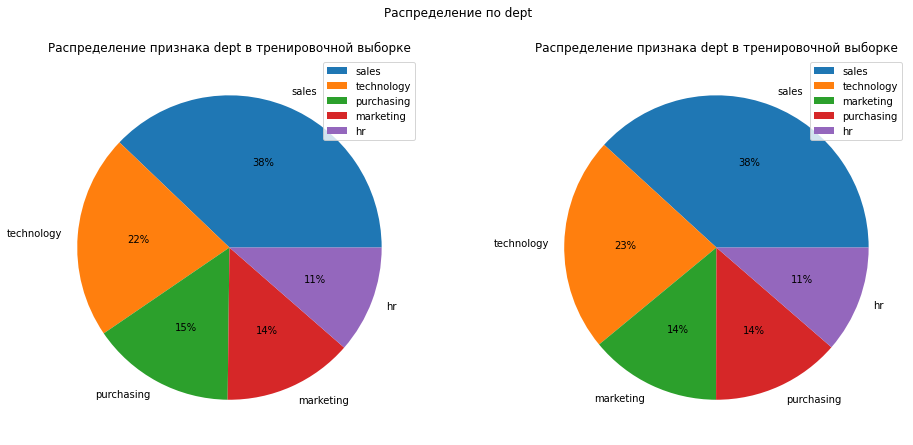

In [21]:
cat_pie(train_satisfaction, test_features, 'dept')

**Вывод**

Распределение работников в различных отделах имеет несбалансированный вид, наибольшее количество сотрудников находится в отделах: sales (38%) и technology (22%). Распределение признака в тренировочной и тестовой выборках практически идентично.

### Признак  `level`

,количество_тренировочная_выборка,количество_тестовая_выборка
level,,
junior,1894,974
middle,1744,854
senior,358,171


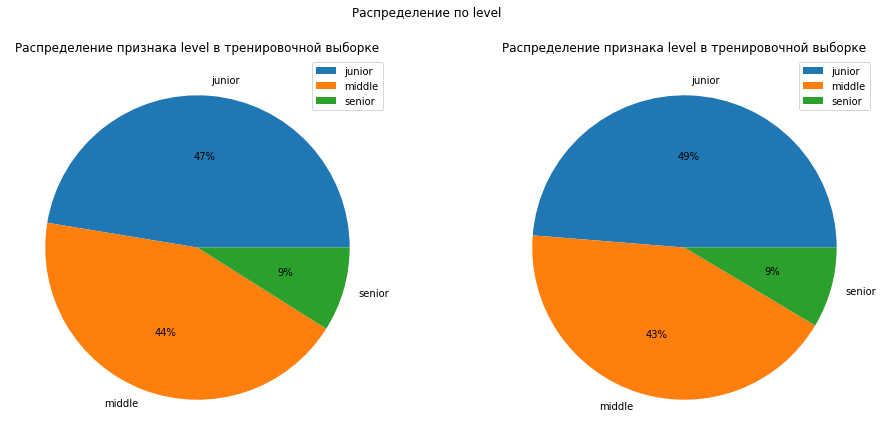

In [22]:
cat_pie(train_satisfaction, test_features, 'level')

**Вывод**

Распределение работников с разным уровнем квалификации имеет следующий вид:
- junior (47%);
- middle (44%);
- senior (9%).
Распределение признака в тренировочной и тестовой выборках практически идентично.

### Признак  `workload`

,количество_тренировочная_выборка,количество_тестовая_выборка
workload,,
high,734,363
low,1200,593
medium,2066,1043


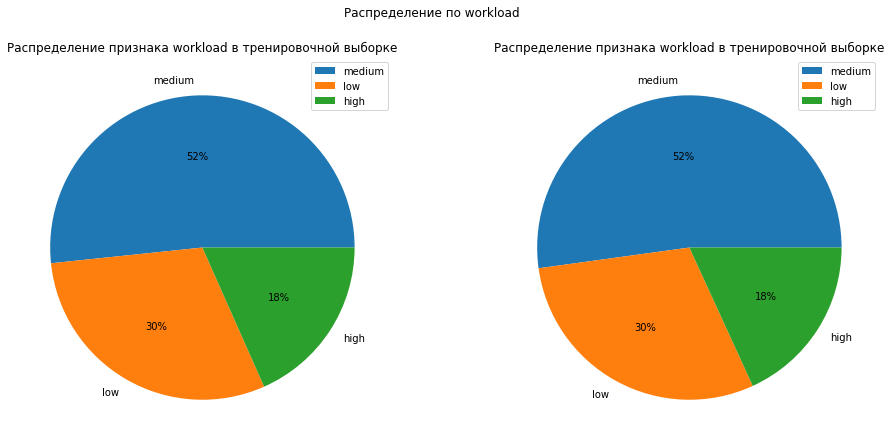

In [23]:
cat_pie(train_satisfaction, test_features, 'workload')

**Вывод**

Распределение работников с разным уровнем нагрузки имеет следующий вид:
- medium (52%);
- low (30%);
- high (18%).

Распределение признака в тренировочной и тестовой выборках практически идентично.

### Признак  `employment_years`

,количество_тренировочная_выборка,количество_тестовая_выборка
employment_years,,
1,966,522
2,785,374
3,483,234
4,384,187
5,380,179
6,287,138
7,301,174
8,193,91
9,130,66


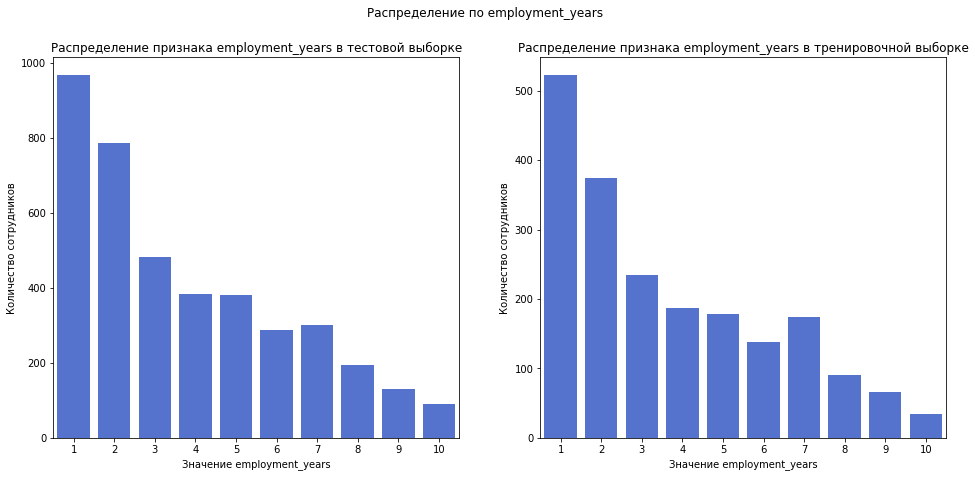

In [24]:
disc_countplot(train_satisfaction, test_features, 'employment_years')

**Вывод**

Распределение длительности работы в компании имеет убывающий тренд с максимумом в 1, то есть чем дольше человек работает в компании, тем меньше вероятность, что останется.
Распределение признака в тренировочной и тестовой выборках практически идентично.

### Признак  `last_year_promo`

,количество_тренировочная_выборка,количество_тестовая_выборка
last_year_promo,,
no,3880,1937
yes,120,63


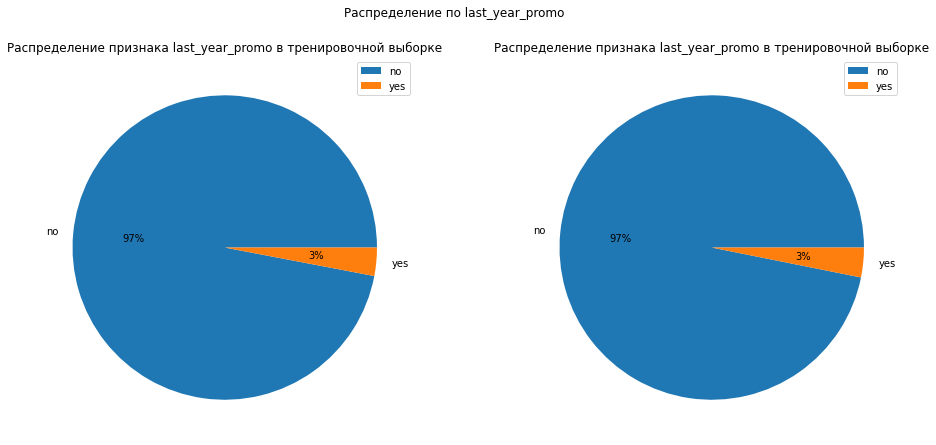

In [25]:
cat_pie(train_satisfaction, test_features, 'last_year_promo')

**Вывод**

Распределение повышения за последний год показывает, что большинство сотрудников (97%) не получало повышения.
Распределение признака в тренировочной и тестовой выборках практически идентично.

### Признак  `last_year_violations`

,количество_тренировочная_выборка,количество_тестовая_выборка
last_year_violations,,
no,3441,1738
yes,559,262


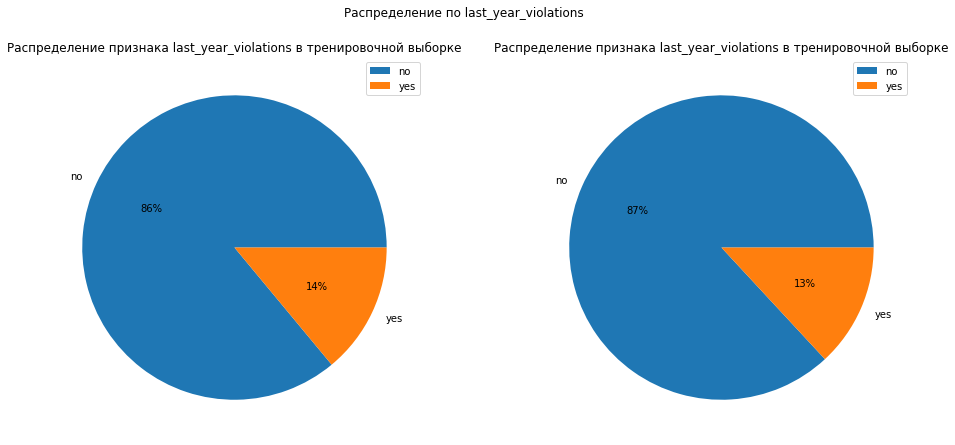

In [26]:
cat_pie(train_satisfaction, test_features, 'last_year_violations')

**Вывод**

Распределение нарушений трудового договора имеет несбалансированный вид. Большая часть работников (86%) не нарушало трудовой договор, что и логично ведь мало людей получают выговоры и вообще нарушают правила.
Распределение признака в тренировочной и тестовой выборках практически идентично.

### Признак  `supervisor_evaluation`

,количество_тренировочная_выборка,количество_тестовая_выборка
supervisor_evaluation,,
1,201,88
2,387,196
3,1263,575
4,1603,857
5,546,284


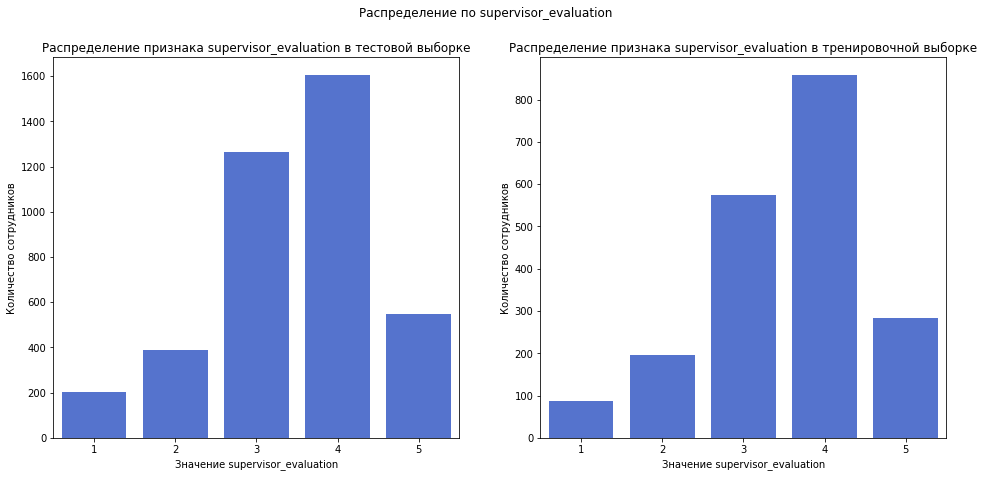

In [27]:
disc_countplot(train_satisfaction, test_features, 'supervisor_evaluation')

**Вывод**

Оценки начальников имеют вид номрального с модой в 4. Можно заметить, что начальники в основном оценивают сотрудников, как средних(3-4), в то время, как отличных и совсем плохих гораздо меньше.
Распределение признака в тренировочной и тестовой выборках практически идентично.

### Признак  `salary`

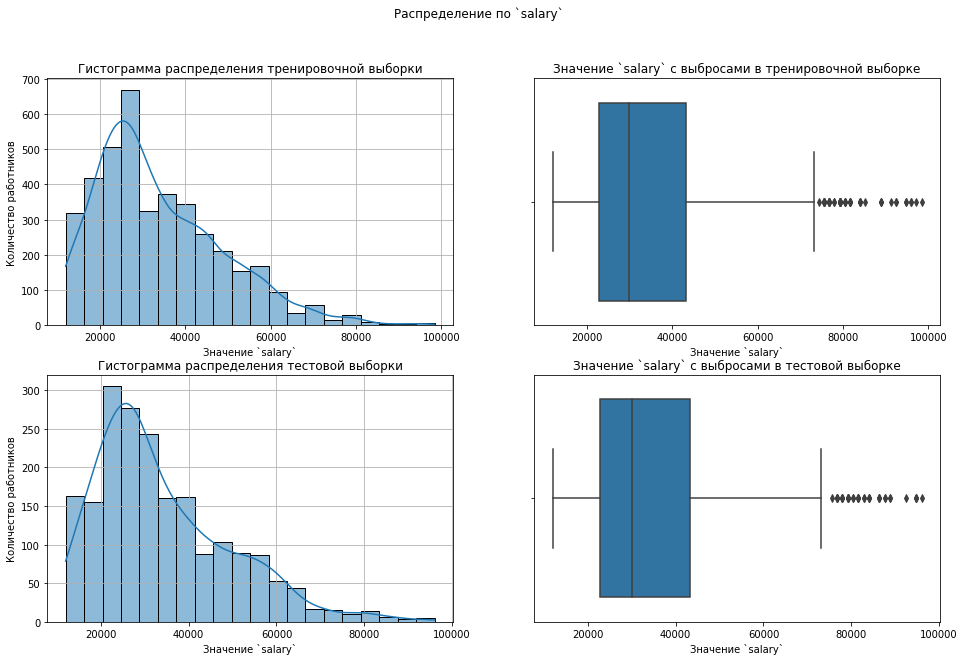

In [28]:
num_hist_box(train_satisfaction, test_features, 'salary')

**Вывод**

Распределение размера зарплаты имеет вид нормального с медианой в 30000, от выбросов нет необходимости избавляться, потому что данные вполне реалистичные.
Распределение признака в тренировочной и тестовой выборках практически идентично.

### Признак  `job_satisfaction_rate`

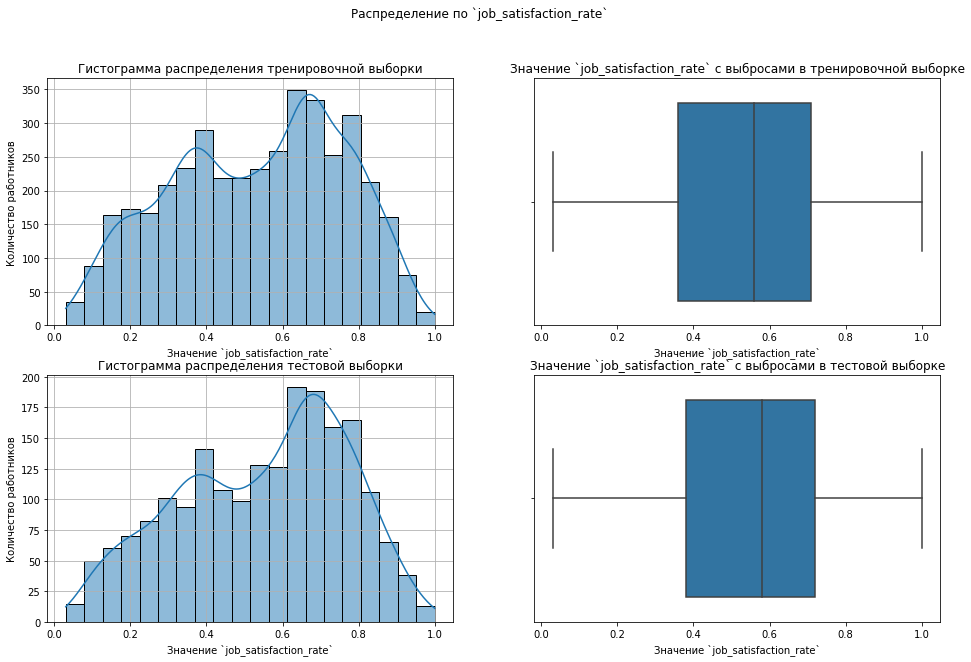

In [29]:
num_hist_box(train_satisfaction, target_satisfaction, 'job_satisfaction_rate')

**Вывод**

Распределение уровня удовлетворенности работой имеет среднее значение 0.53, выбросов не обнаружено.
Распределение признака в тренировочной и тестовой выборках практически идентично.

### Вывод

По исследовательскому анализу можно сделать следующие выводы:
- Признак `dept`. Распределение работников в различных отделах имеет несбалансированный вид, наибольшее количество сотрудников находится в отделах: sales (38%) и technology (22%).
- Признак `level`. Распределение работников с разным уровнем квалификации имеет следующий вид:
    - junior (47%);
    - middle (44%);
    - senior (9%).
- Признак `workload`. Распределение работников с разным уровнем нагрузки имеет следующий вид:
    - medium (52%);
    - low (30%);
    - high (18%).
- Признак `employment_years`. Распределение длительности работы в компании имеет убывающий тренд с максимумом в 1, то есть чем дольше человек работает в компании, тем меньше вероятность, что он останется.
- Признак `last_year_promo`. Распределение повышения за последний год показывает, что большинство сотрудников (97%) не получало повышения.
- Признак `last_year_violations`. Распределение нарушений трудового договора имеет несбалансированный вид. Это является нормальной ситуацией, что большая часть работников (87%) не нарушало трудовой договор. Для более детального исследования можно добавить информацию, по каким пунктам нарушили его остальные 13%.
- Признак `supervisor_evaluation`. Оценки начальников имеют вид номрального с модой в 4. Можно заметить, что начальники в основном оценивают сотрудников, как средних(3-4), в то время, как отличных и совсем плохих гораздо меньше.
- Признак `salary`. Распределение размера зарплаты имеет вид нормального с медианой в 30000, от выбросов нет необходимости избавляться, потому что данные вполне реалистичные.
- Признак `job_satisfaction_rate`. Распределение уровня удовлетворенности работой имеет среднее значение 0.53, выбросов не обнаружено.
    

- Общий вывод:
    - Данные пригодны для дальнейшего исследования, изменений не внесено. Распределние тренировочной и тестовой выборок практически идентично для всех признаков.

## Корреляционный анализ №1

Перед созданием моделей машинного обучения необходимо провести корреляционный анализ, чтобы выяснить с чем коррелирует целевой признак и есть ли линейно-зависимые переменные.

### Тренировочные данные

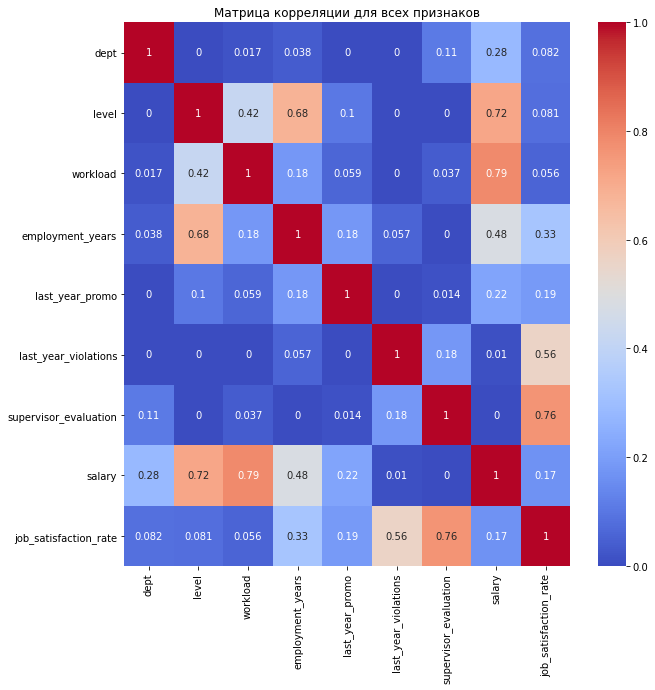

In [30]:
#Матрица корреляции со всеми признаками
plt.figure(figsize=(10, 10))
sns.heatmap(train_satisfaction
    .drop('id', axis=1)
    .phik_matrix(interval_cols=[
        'salary',
        'job_satisfaction_rate']),
        annot=True, 
        cmap='coolwarm')
plt.title('Матрица корреляции для всех признаков')
plt.show();

### Тестовые данные

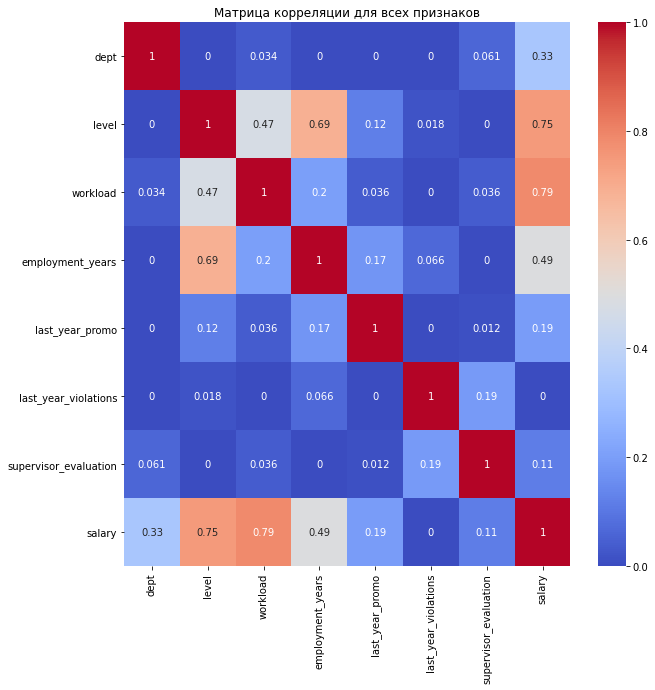

In [31]:
#Матрица корреляции со всеми признаками
plt.figure(figsize=(10, 10))
sns.heatmap(test_features
    .drop('id', axis=1)
    .phik_matrix(interval_cols=[
        'salary',
        'job_satisfaction_rate']),
        annot=True, 
        cmap='coolwarm')
plt.title('Матрица корреляции для всех признаков')
plt.show();

### Вывод

В ходе корреляционного анализа были сделаны следующие выводы:
- Зависимости тестовой и тренировочной выборок практически идентичны;
- Между признаками `workload` и `salary` наблюдается высокая корреляция (0.79), но поскольку она меньше 0.9, мы не можем говорить о мультиколлинеарности;
- Целевой признак `job_satisfaction_rate` имеет заметную и высокую корреляцию со следующими признаками:
    - `last_year_violations` (0.56);
    - `supervisor_evaluation` (0.76).

## Построение моделей машинного обучения №1

### Подготовка данных


In [32]:
train_data_satisfaction = train_satisfaction.copy(deep=True)
train_data_satisfaction.set_index('id', inplace=True)
train_data_satisfaction.duplicated().sum()

245

In [33]:
train_data_satisfaction.drop_duplicates(inplace=True)
train_data_satisfaction.duplicated().sum()

0

In [34]:
test_data_satisfaction = test_features.merge(target_satisfaction, on='id')

X_train = train_data_satisfaction.drop('job_satisfaction_rate', axis=1)
y_train = train_data_satisfaction['job_satisfaction_rate']
X_test = test_data_satisfaction.drop(['id', 'job_satisfaction_rate'], axis=1)
y_test = test_data_satisfaction['job_satisfaction_rate']

ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

In [35]:
def SMAPE(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred))))
SMAPE_score = make_scorer(SMAPE, greater_is_better=False)

### Разработка пайплайна

In [36]:
RANDOM_STATE = 42
# Создаем пайплайны для подготовки признаков
ohe_pipe= Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))])

In [37]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[['junior', 'middle', 'senior'],
                   ['low', 'medium', 'high']],
        handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', MinMaxScaler(), num_columns)],
    remainder='passthrough')

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [38]:
param_grid = [
    #Словарь для модели DecisionTreeRegressor
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__min_samples_split': range(2, 22),
        'models__max_features': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    #Словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }, 
] 

In [39]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5, 
    scoring=SMAPE_score, 
    n_jobs=-1,
    random_state=RANDOM_STATE
)

#обучение модели на тренировочной выборке
randomized_search.fit(X_train, y_train);

In [40]:
print(f'Метрика SMAPE для лучшей модели: {round(-randomized_search.best_score_, 2)}\n') 
print(f'Лучшая модель и её параметры:\n{randomized_search.best_params_}\n') 

Метрика SMAPE для лучшей модели: 15.29

Лучшая модель и её параметры:
{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 7, 'models__max_features': 13, 'models__max_depth': 16, 'models': DecisionTreeRegressor(random_state=42)}



### Проверка на тестовых данных

In [41]:
best_model = randomized_search.best_estimator_['models']
best_model_preprocessor = randomized_search.best_estimator_['preprocessor']

X_test_encoded = best_model_preprocessor.transform(X_test)
y_pred = best_model.predict(X_test_encoded)
print ('Метрика лучшей модели на тестовой выборке:', (SMAPE(y_test, y_pred)).round(2))

Метрика лучшей модели на тестовой выборке: 13.75


### Анализ важности признаков

,Feature,Importance
9,num__supervisor_evaluation,0.662394
10,num__salary,0.087432
8,num__employment_years,0.073591
5,ohe__last_year_violations_yes,0.053500
6,ord__level,0.051219
7,ord__workload,0.020659
2,ohe__dept_sales,0.014103
4,ohe__last_year_promo_yes,0.012682
3,ohe__dept_technology,0.010329
0,ohe__dept_marketing,0.010216


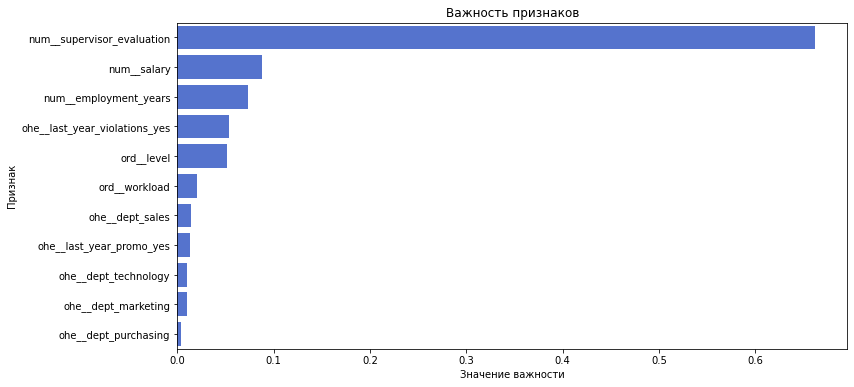

In [42]:
# Получение названий столбцов
feature_names = best_model_preprocessor.get_feature_names_out()

feature_importances = pd.DataFrame(
    {
        'Feature': feature_names,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

display(feature_importances)

plt.figure(figsize=(12, 6))
sns.barplot(data = feature_importances, x='Importance', y='Feature', color='#4169e1')
plt.title('Важность признаков')
plt.xlabel('Значение важности')
plt.ylabel('Признак')
plt.show()

### Вывод

В ходе разработки моделей машинного обучения можно сделать следующие выводы:
- Моделью, показавшей наилучшие показатели SMAP, является модель DecisionTreeRegressor(max_depth=16, min_samples_split=7, max_features=13, random_state=42) со скелером StandardScaler();
- На тестовых данных лучшая модель показала 13.8 баллов;
- Наиболее важными признаками модели являются:
    - supervisor_evaluation (0.67);
    - salary (0.09);
    - employment_years (0.08).

## Исследовательский анализ №2

Проведем исследовательский анализ для второй задачи сразу для 3 датасетов: `train_quit`, `test_features` и `target_quit`. Оценим данные на выбросы и распределение, а также сравним распределения тренировочной и тестовой выборок.

In [43]:
def hist_comparison(df, feature, comp_feature):

    # строим гистограмму    
    plot = sns.histplot(df, bins=20, x=feature, hue=comp_feature, stat='density', common_norm=False, kde=True)
    plot.set(
        title = 'Нормированная гистограмма распределения',
        xlabel = f'Значение `{feature}`',
        ylabel = 'Плотность распределения')
    plt.grid();
    
def pie_comparison(df_quit, df_no_quit, feature):
    df_1 = df_quit.pivot_table(
        index=feature,
        values='id',
        aggfunc='count').rename(columns={'id': 'количество'})
    df_2 = df_no_quit.pivot_table(
        index=feature,
        values='id',
        aggfunc='count').rename(columns={'id': 'количество'})
    total_df = pd.concat([
        df_1.add_suffix('_уволившихся'),
        df_2.add_suffix('_не_уволившихся')],
        axis=1)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize= (16,7))
    plt.suptitle(f'Распределение по {feature}')
    ax[0].pie(
        df_quit[feature].value_counts(),
        autopct='%1.0f%%',
        labels=dict(df_quit[feature].value_counts()).keys())
    ax[0].set_title(f'Распределение признака {feature} в выборке уволившихся')
    ax[0].legend(loc='best')
    
    ax[1].pie(
        df_no_quit[feature].value_counts(),
        autopct='%1.0f%%',
        labels=dict(df_no_quit[feature].value_counts()).keys())
    ax[1].set_title(f'Распределение признака {feature} в выборке неуволившихся')
    ax[1].legend(loc='best')
    return total_df

def countplot_comparison(df_train, df_test, feature):
    df_1 = df_train.pivot_table(
        index=feature,
        values='id',
        aggfunc='count').rename(columns={'id': 'количество'})
    df_2 = df_test.pivot_table(
        index=feature,
        values='id',
        aggfunc='count').rename(columns={'id': 'количество'})
    total_df = pd.concat([
        df_1.add_suffix('_тренировочная_выборка'),
        df_2.add_suffix('_тестовая_выборка')],
        axis=1)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize= (16,7))
    plt.suptitle(f'Распределение по {feature}')
    
    sns.countplot(data=df_train, x=feature, ax=ax[0], color='#4169e1')
    ax[0].set(
        title=f'Распределение признака {feature} в тренировочной выборке',
        xlabel=f'Значение {feature}',
        ylabel=f'Количество сотрудников')
    
    sns.countplot(data=df_test, x=feature, ax=ax[1], color='#4169e1')
    ax[1].set(
        title=f'Распределение признака {feature} в тестовой выборке',
        xlabel=f'Значение {feature}',
        ylabel=f'Количество сотрудников')
    return total_df

def countplot_comparison_hue(df_quit, feature, hue):    
    plot = sns.countplot(data=df_quit, x=feature, hue=hue)
    plot.set(
        title=f'Распределение признака {feature} в тренировочной выборке',
        xlabel=f'Значение {feature}',
        ylabel=f'Количество сотрудников')
    plt.grid()

In [44]:
train_quit_no = train_quit.query('quit == "no"')
train_quit_yes = train_quit.query('quit == "yes"')

print(train_quit_yes.shape)
print(train_quit_no.shape)

(1128, 10)
(2872, 10)


### Признак  `dept`

,количество_тренировочная_выборка,количество_тестовая_выборка
dept,,
hr,464,227
marketing,582,279
purchasing,588,273
sales,1438,763
technology,928,455


,количество_уволившихся,количество_не_уволившихся
dept,,
hr,116,348
marketing,163,419
purchasing,166,422
sales,407,1031
technology,276,652


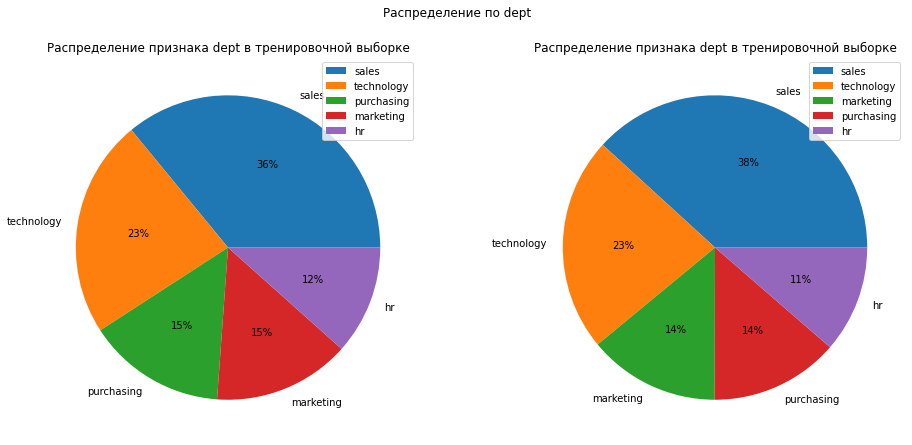

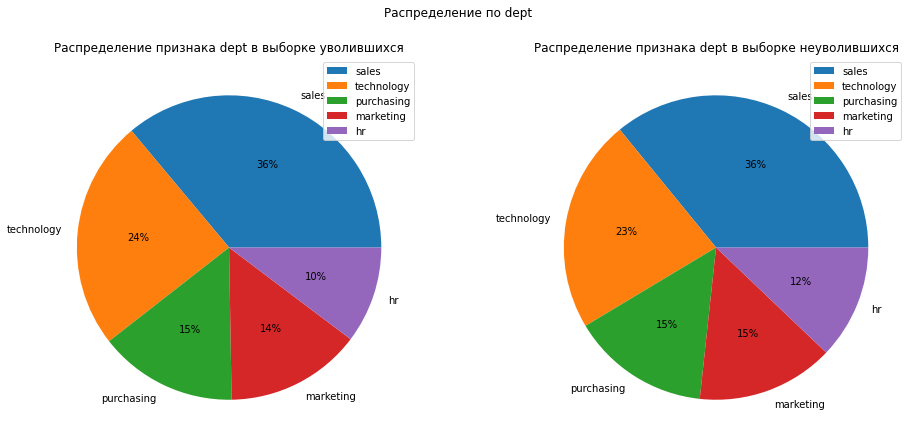

In [45]:
display(cat_pie(train_quit, test_features, 'dept'))
display(pie_comparison(train_quit_yes, train_quit_no, 'dept'))

**Вывод**

Распределение работников в различных отделах имеет несбалансированный вид, наибольшее количество сотрудников находится в отделах: sales (36%) и technology (23%). Распределение признака в тренировочной и тестовой выборках практически идентично. Распределение признака в выборке уволившихся и неуволившихся практически идентичное.

### Признак  `level`

,количество_тренировочная_выборка,количество_тестовая_выборка
level,,
junior,1949,974
middle,1694,854
senior,357,171


,количество_уволившихся,количество_не_уволившихся
level,,
junior,1003,946
middle,108,1586
senior,17,340


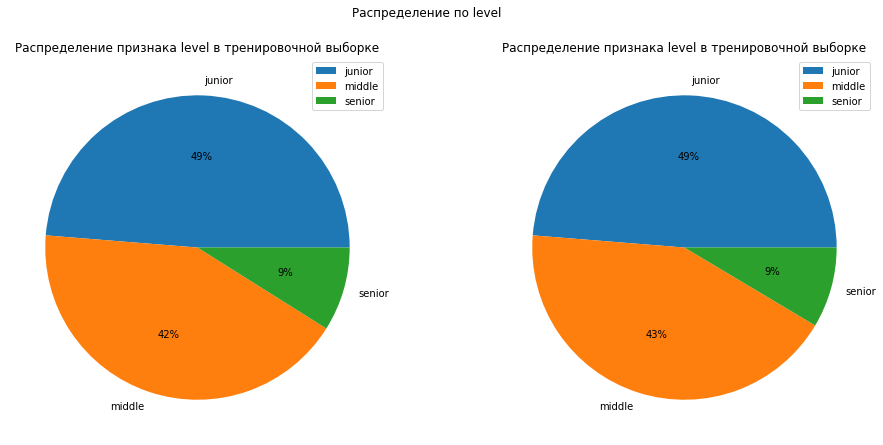

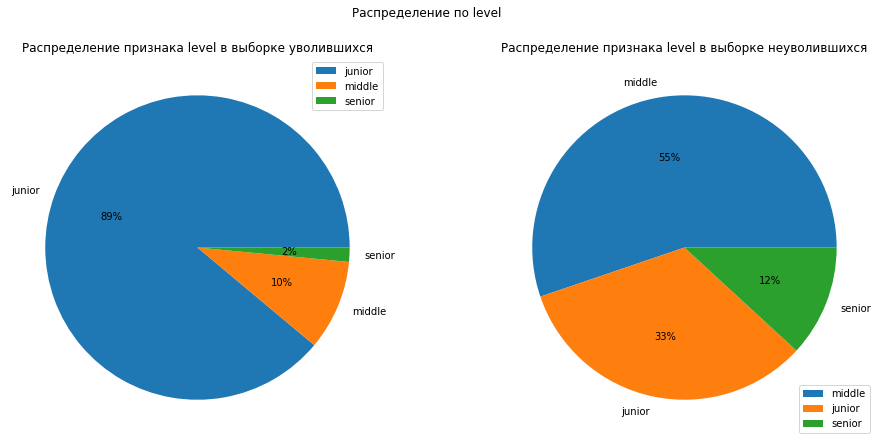

In [46]:
display(cat_pie(train_quit, test_features, 'level'))
display(pie_comparison(train_quit_yes, train_quit_no, 'level'))

**Вывод**

Распределение работников с разным уровнем квалификации имеет следующий вид:
- junior (49%);
- middle (42%);
- senior (9%).

Распределение признака в тренировочной и тестовой выборках практически идентично.

Среди уволившихся большинство (89%) являются сотрудниками уровня Junior, в то время как у неуволившихся большинство (55%) сотрудников уровня Middle.

### Признак  `workload`

,количество_тренировочная_выборка,количество_тестовая_выборка
workload,,
high,674,363
low,1208,593
medium,2118,1043


,количество_уволившихся,количество_не_уволившихся
workload,,
high,121,553
low,519,689
medium,488,1630


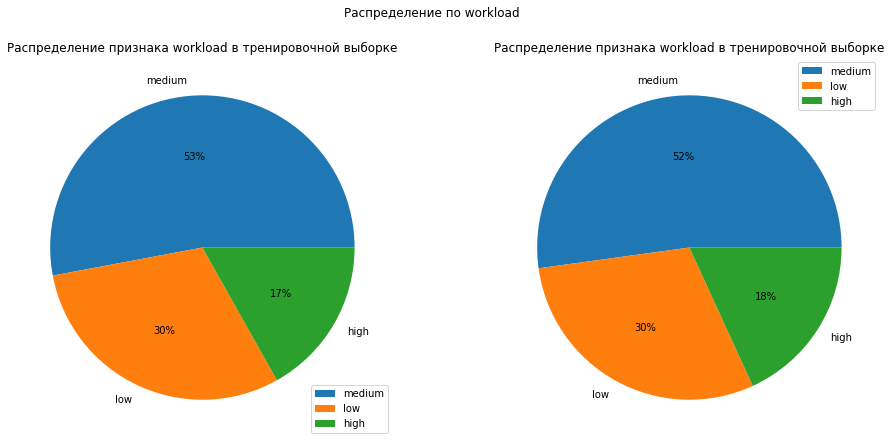

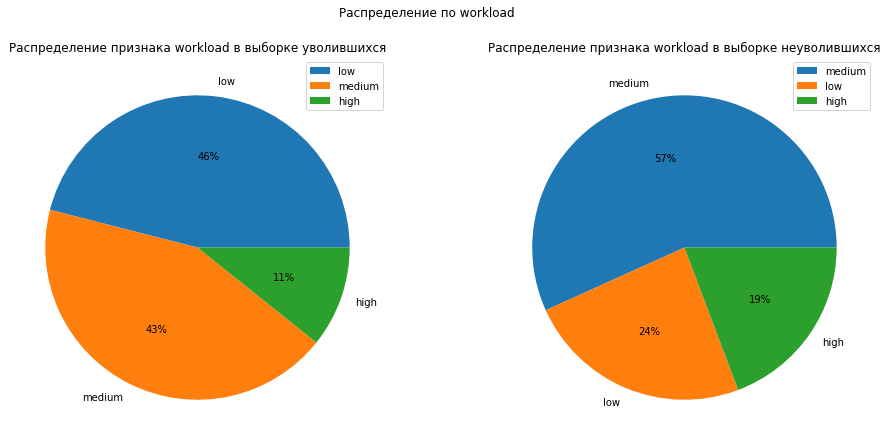

In [47]:
display(cat_pie(train_quit, test_features, 'workload'))
display(pie_comparison(train_quit_yes, train_quit_no, 'workload'))

**Вывод**

Распределение работников с разным уровнем нагрузки имеет следующий вид:
- medium (53%);
- low (30%);
- high (17%).

Распределение признака в тренировочной и тестовой выборках практически идентично. Соотношение уровней у неуволившихся сотрудников схоже с основной выборкой.

Уволившиеся сотрудники в основном имеют следующие уровни загруженности:
- low (46%);
- medium (43%);
- high (11%).

### Признак  `employment_years`

,количество_тренировочная_выборка,количество_тестовая_выборка
employment_years,,
1,985,522
2,777,374
3,479,234
4,393,187
5,362,179
6,296,138
7,308,174
8,174,91
9,136,66


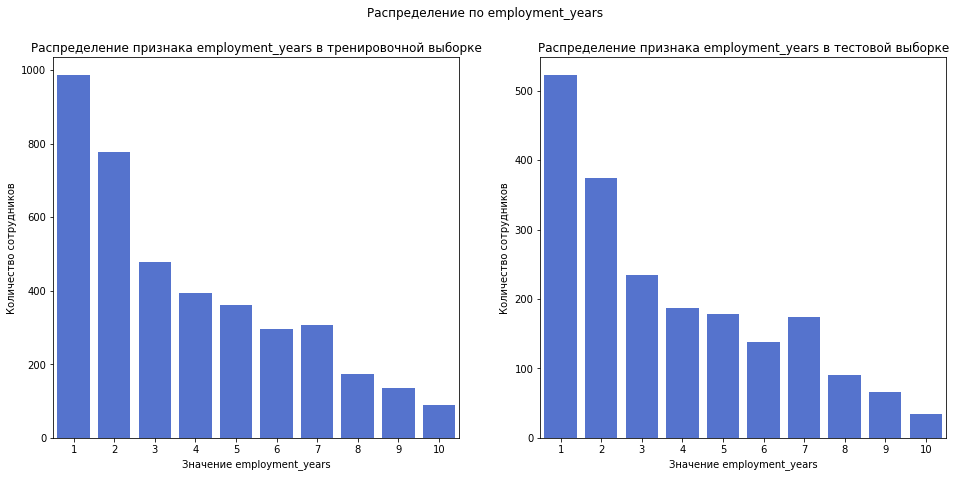

In [48]:
countplot_comparison(train_quit, test_features, 'employment_years')

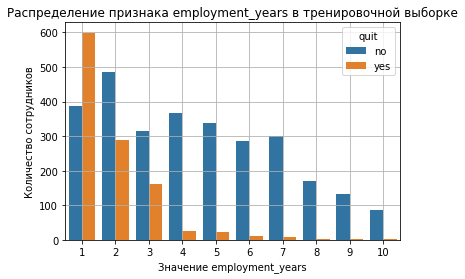

In [49]:
countplot_comparison_hue(train_quit, 'employment_years', 'quit')

,количество_уволившихся,количество_не_уволившихся
employment_years,,
1,599,386
2,290,487
3,163,316
4,27,366
5,23,339
6,10,286
7,7,301
8,3,171
9,3,133


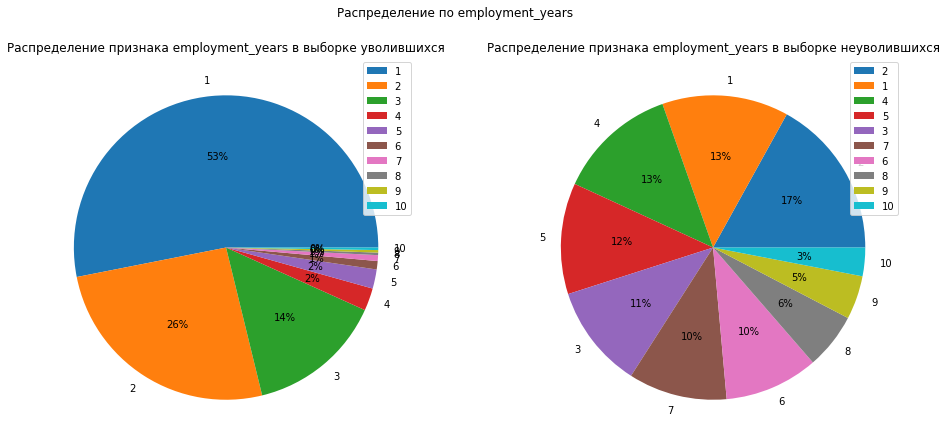

In [50]:
pie_comparison(train_quit_yes, train_quit_no, 'employment_years')

**Вывод**

Распределение длительности работы в компании имеет убывающий тренд с максимумом в 1, то есть чем дольше человек работает в компании, тем меньше вероятность, что останется.
Распределение признака в тренировочной и тестовой выборках практически идентично.

Уволившиеся сотрудники увольняются в основном в первые 3 года работы, в основном в первый год.

### Признак  `last_year_promo`

,количество_тренировочная_выборка,количество_тестовая_выборка
last_year_promo,,
no,3887,1937
yes,113,63


,количество_уволившихся,количество_не_уволившихся
last_year_promo,,
no,1127,2760
yes,1,112


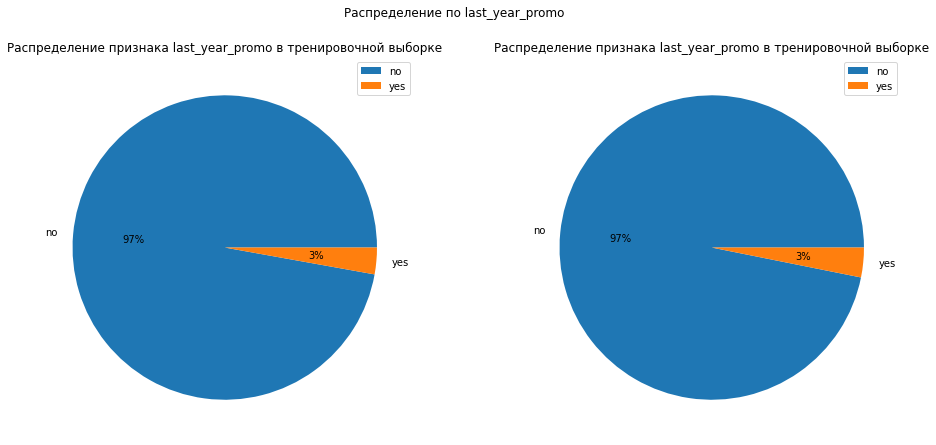

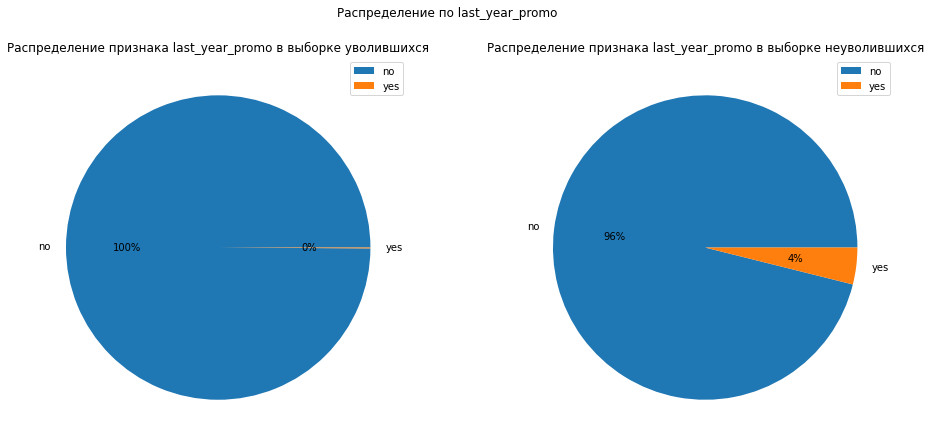

In [51]:
display(cat_pie(train_quit, test_features, 'last_year_promo'))
display(pie_comparison(train_quit_yes, train_quit_no, 'last_year_promo'))

**Вывод**

Распределение повышения за последний год показывает, что большинство сотрудников (97%) не получало повышения.
Распределение признака в тренировочной и тестовой выборках практически идентично.

Среди уволившихся сотрудников лишь 1 человек из 1127 получил повышение, в то время как у неуволившихся 4 процента получили повышение.

### Признак  `last_year_violations`

,количество_тренировочная_выборка,количество_тестовая_выборка
last_year_violations,,
no,3455,1738
yes,545,262


,количество_уволившихся,количество_не_уволившихся
last_year_violations,,
no,900,2555
yes,228,317


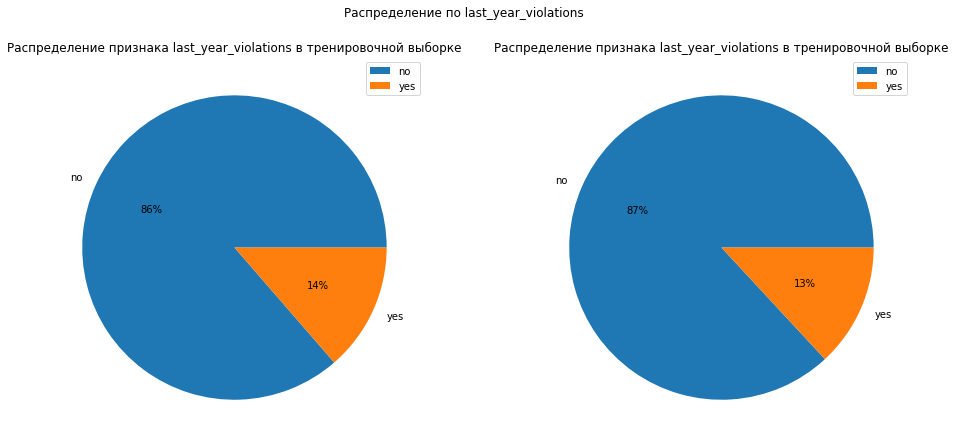

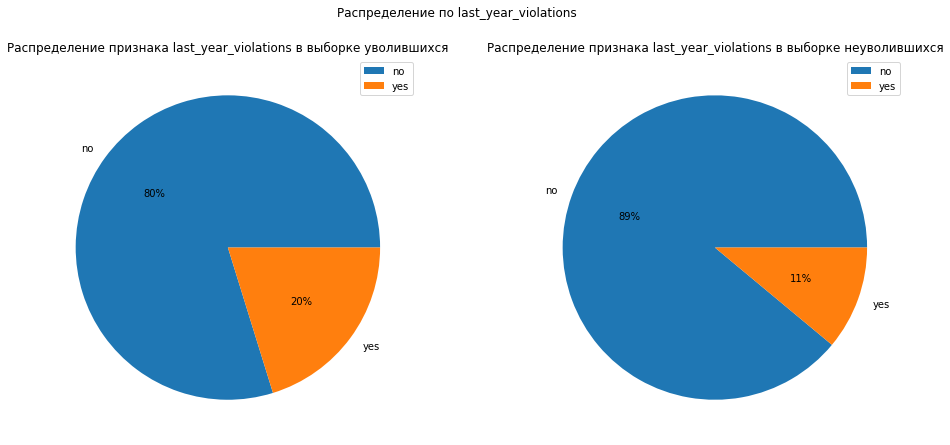

In [52]:
display(cat_pie(train_quit, test_features, 'last_year_violations'))
display(pie_comparison(train_quit_yes, train_quit_no, 'last_year_violations'))

**Вывод**

Распределение нарушений трудового договора имеет несбалансированный вид. Большая часть работников (86%) не нарушало трудовой договор, остальные 14% его нарушали.
Распределение признака в тренировочной и тестовой выборках практически идентично.

Среди уволившихся нарушений трудового договора выше, чем в основной выборке, вероятно, это связано с тем, что после нарушения трудового договора человек не хочет оставаться или вынужден уйти с работы. У неуволившихся значение нарушений наоборот становится меньше.

### Признак  `supervisor_evaluation`

,количество_тренировочная_выборка,количество_тестовая_выборка
supervisor_evaluation,,
1,202,88
2,391,196
3,1233,575
4,1654,857
5,520,284


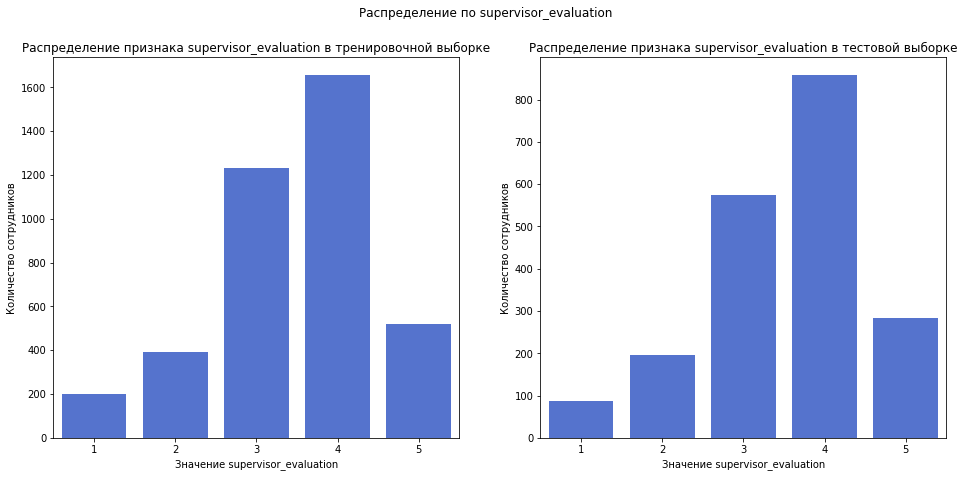

In [53]:
countplot_comparison(train_quit, test_features, 'supervisor_evaluation')

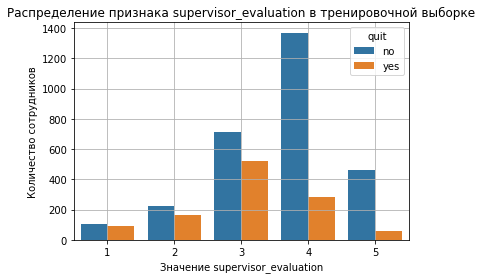

In [54]:
countplot_comparison_hue(train_quit, 'supervisor_evaluation', 'quit')

,количество_уволившихся,количество_не_уволившихся
supervisor_evaluation,,
1,95,107
2,164,227
3,523,710
4,286,1368
5,60,460


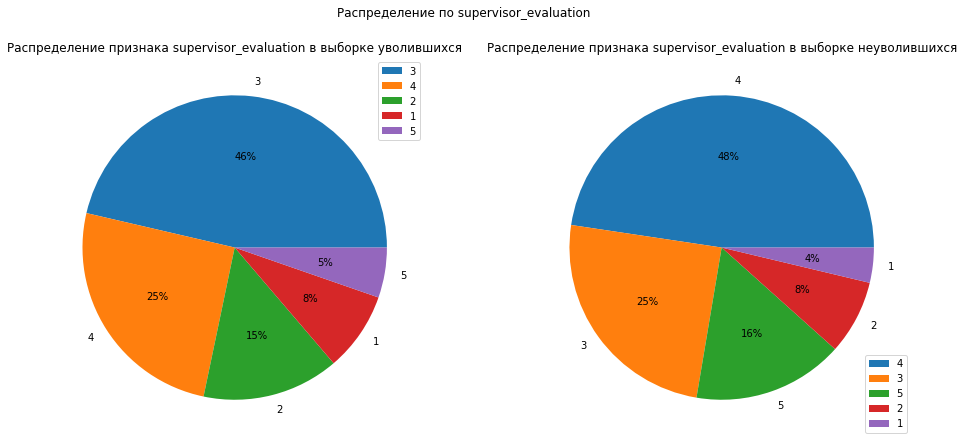

In [55]:
pie_comparison(train_quit_yes, train_quit_no, 'supervisor_evaluation')

Статистически проверим гипотезу о том, что оценка руководителя ниже у уволившихся сотрудников.

Нулевая гипотеза: оценка руководителя у уволившихся и неуволившихся одинакова.

Альтернативная гипотеза: оценка руководителя у уволившихся ниже, чем у неуволившихся.

In [56]:
alpha = 0.05

results = st.ttest_ind(
    train_quit_yes['supervisor_evaluation'], 
    train_quit_no['supervisor_evaluation'], 
    alternative='less')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 7.42906192784865e-67
Отвергаем нулевую гипотезу


**Вывод**

Оценки начальников имеют вид нормального с модой в 4. Можно заметить, что начальники в основном оценивают сотрудников, как средних(3-4), в то время, как отличных и совсем плохих гораздо меньше.
Распределение признака в тренировочной и тестовой выборках практически идентично.

Распределение уволившихся свдигается в сторону меньших баллов, так например, мода для уволившихся сотрудников равна 3. Статистически есть основания полагать, что действительно оценки руководителей ниже у уволившихся сотрудников.

### Признак  `salary`

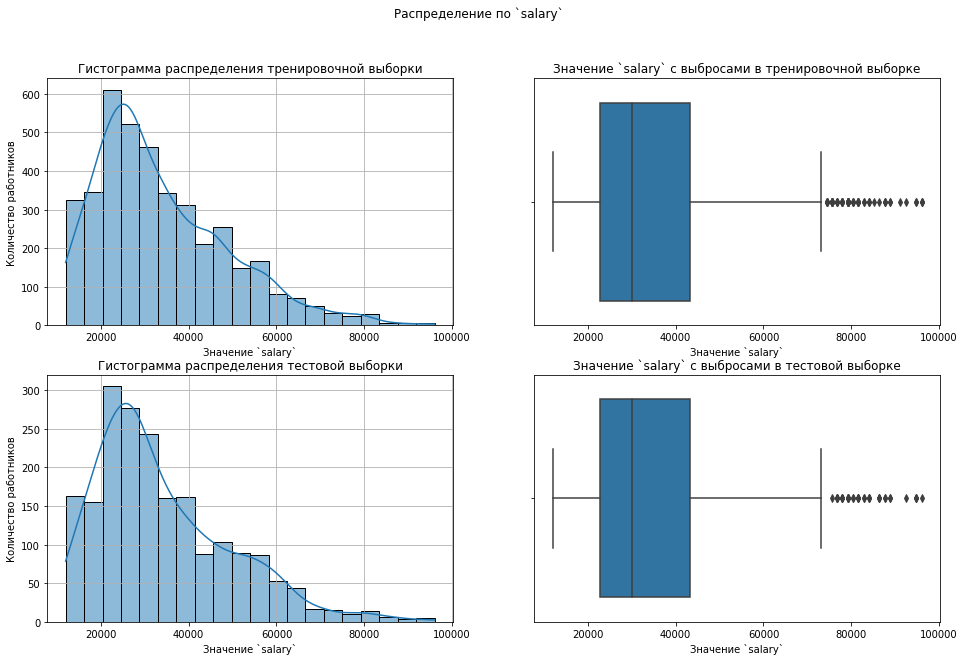

In [57]:
num_hist_box(train_quit, test_features, 'salary')

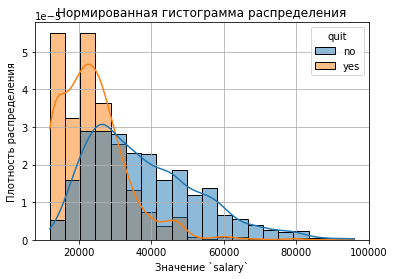

In [58]:
hist_comparison(train_quit, 'salary', 'quit')

Статистически проверим гипотезу о том, что зарплата ниже у уволившихся сотрудников.

Нулевая гипотеза: зарплата у уволившихся и неуволившихся одинакова.

Альтернативная гипотеза: зарплата у уволившихся ниже, чем у неуволившихся.

In [59]:
alpha = 0.05

#train_quit_no_group = train_quit_no.sample(n=1128, random_state=RANDOM_STATE)
results = st.ttest_ind(
    train_quit_yes['salary'], 
    train_quit_no['salary'], 
    alternative='less')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.232068933994945e-162
Отвергаем нулевую гипотезу


In [60]:
df_yes = pd.DataFrame(data=train_quit_yes['salary'].describe())
df_no = pd.DataFrame(data=train_quit_no['salary'].describe())
df_mean = pd.concat([
    df_yes.add_suffix('_уволившиеся'),
    df_no.add_suffix('_неуволившиеся')],
    axis=1)

df_mean

,salary_уволившиеся,salary_неуволившиеся
count,1128.000000,2872.000000
mean,23885.106383,37702.228412
std,9351.599505,15218.977339
min,12000.000000,12000.000000
25%,16800.000000,25200.000000
50%,22800.000000,34800.000000
75%,27600.000000,46800.000000
max,79200.000000,96000.000000


**Вывод**

Распределение размера зарплаты имеет вид нормального с медианой в 30000, от выбросов нет необходимости избавляться в связи со спецификой данных.
Распределение признака в тренировочной и тестовой выборках практически идентично.

По распределению уволившихся можно заметить, что их зарплата ниже, чем у неуволившихся. Статистически доказано, что с большей долей вероятности зарплата уволившихся сотрудников ниже. Это подтверждено также таблицей с основными статистическими характеристиками, средняя зарплата уволившихся равна 23885, в то время как у неуволившихся 37702.

### Признак  `quit`

,количество_тренировочная_выборка,количество_тестовая_выборка
quit,,
no,2872,1436
yes,1128,564


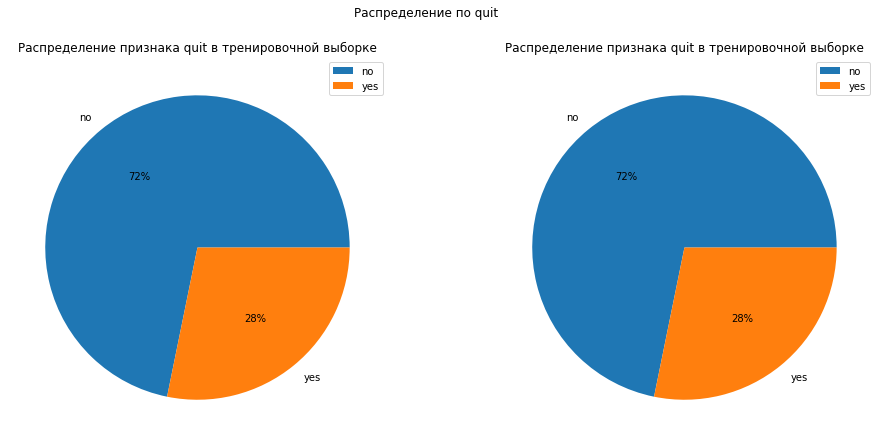

In [61]:
cat_pie(train_quit, target_quit, 'quit')

**Вывод**

Распределение признака имеет несбалансированный вид:
- Неуволившиеся (72%);
- Уволившиеся (28%).

Распределение признака в тренировочной и тестовой выборках практически идентично.

### Уровень удовлетворенности работой

In [62]:
test_features_quit = test_features.merge(target_satisfaction, on='id')
test_features_quit = test_features_quit.merge(target_quit, on='id')
display(test_features_quit.head())
test_features_quit.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.72,no
2,467458,sales,middle,low,5,no,no,4,19200,0.64,no
3,418655,sales,middle,low,6,no,no,4,19200,0.60,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.75,no


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1997 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               1999 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
 10  quit                   2000 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 187.5+ KB


In [63]:
def graphic_scatter(data, x, y, hue):
    plt.figure(figsize=(7,7))
    sns.scatterplot(
        data=data,
        x=x,
        y=y,
        hue=hue)
    plt.title(f'График зависимости {x} от {y}')
    plt.show()

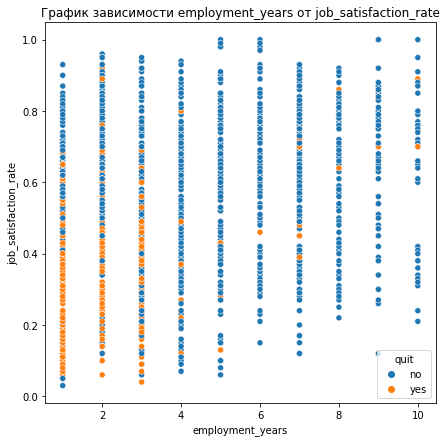

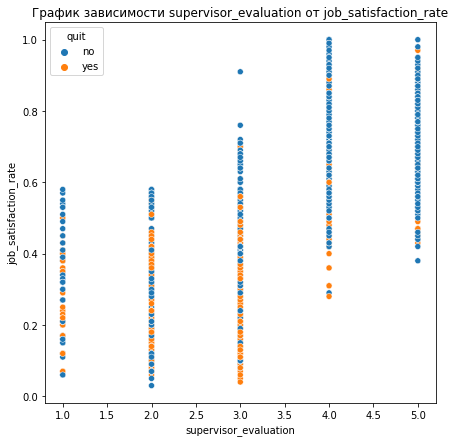

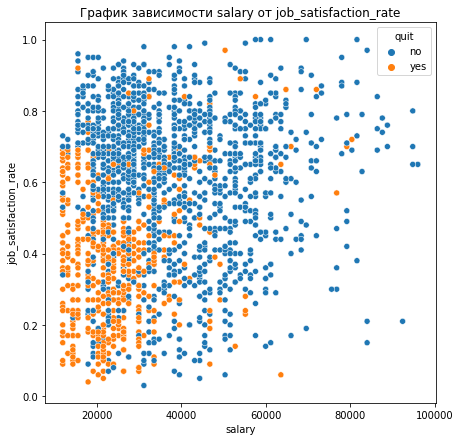

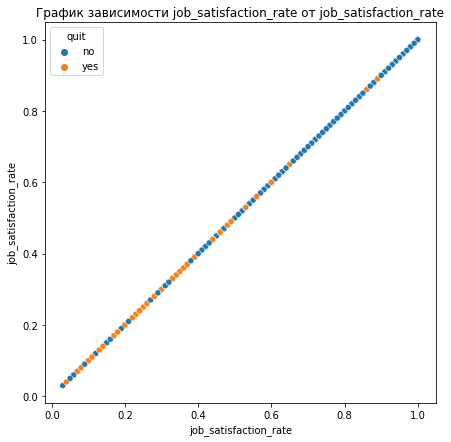

In [64]:
num_features = list(
    test_features_quit.loc[:, ~test_features_quit.columns.isin(['id'])]
    .select_dtypes(include='number').columns)
for col in num_features:
    graphic_scatter(test_features_quit, col, 'job_satisfaction_rate', 'quit')

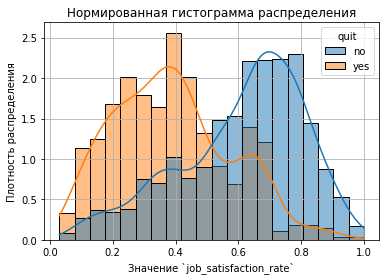

In [65]:
hist_comparison(test_features_quit, 'job_satisfaction_rate', 'quit')

In [66]:
test_features_quit_yes = test_features_quit.query('quit == "yes"')
test_features_quit_no = test_features_quit.query('quit == "no"')

print(test_features_quit_yes.shape)
print(test_features_quit_no.shape)

(564, 11)
(1436, 11)


In [67]:
alpha = 0.05

test_features_quit_no_group = test_features_quit_no.sample(n=564, random_state=RANDOM_STATE)
results = st.ttest_ind(
    test_features_quit_yes['salary'], 
    test_features_quit_no['salary'], 
    alternative='less')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.4495568956891524e-66
Отвергаем нулевую гипотезу


### Вывод

По исследовательскому анализу можно сделать следующие выводы:
- Признак `dept`. 
    - Распределение работников в различных отделах имеет несбалансированный вид, наибольшее количество сотрудников находится в отделах: sales (36%) и technology (23%). 
    - Распределение признака в выборке уволившихся и неуволившихся практически идентичное.
- Признак `level`. 
    - Распределение работников с разным уровнем квалификации имеет следующий вид:
        - junior (49%);
        - middle (42%);
        - senior (9%).
    - Среди уволившихся большинство (89%) являются сотрудниками уровня Junior, в то время как у неуволившихся большинство (55%) сотрудников уровня Middle.
- Признак `workload`. 
    - Распределение работников с разным уровнем нагрузки имеет следующий вид:
        - medium (53%);
        - low (30%);
        - high (17%).
    - Соотношение уровней у неуволившихся сотрудников схоже с основной выборкой. Уволившиеся сотрудники в основном имеют следующие уровни загруженности:
        - low (46%);
        - medium (43%);
        - high (11%).
- Признак `employment_years`. 
    - Распределение длительности работы в компании имеет убывающий тренд с максимумом в 1, то есть чем дольше человек работает в компании, тем меньше вероятность, что он останется.
    - Уволившиеся сотрудники увольняются в основном в первые 3 года работы, в основном в первый год, в то время, как неуволившиеся работают равномерно несколько лет.
- Признак `last_year_promo`. 
    - Распределение повышения за последний год показывает, что большинство сотрудников (97%) не получало повышения.
    - Среди уволившихся сотрудников лишь 1 человек из 1127 получил повышение, в то время как у неуволившихся 4 процента получили повышение.
- Признак `last_year_violations`. 
    - Распределение нарушений трудового договора имеет несбалансированный вид. Это является нормальной ситуацией, что большая часть работников (87%) не нарушало трудовой договор. Для более детального исследования можно добавить информацию, по каким пунктам нарушили его остальные 13%.
    - Среди уволившихся нарушений трудового договора выше, чем в основной выборке, вероятно, это связано с тем, что после нарушения трудового договора человек не хочет оставаться или вынужден уйти с работы. У неуволившихся значение нарушений наоборот становится меньше.
- Признак `supervisor_evaluation`. 
    - Оценки начальников имеют вид номрального с модой в 4. Можно заметить, что начальники в основном оценивают сотрудников, как средних(3-4), в то время, как отличных и совсем плохих гораздо меньше.
    - Распределение уволившихся свдигается в сторону меньших баллов, так например, мода для уволившихся сотрудников равна 3. Статистически есть основания полагать, что действительно оценки руководителей ниже у уволившихся сотрудников.
- Признак `salary`. 
    - Распределение размера зарплаты имеет вид нормального с медианой в 30000, от выбросов нет необходимости избавляться, потому что данные вполне реалистичные.
    - По распределению уволившихся можно заметить, что их зарплата ниже, чем у неуволившихся. Статистически доказано, что с большей долей вероятности зарплата уволившихся сотрудников ниже. Это подтверждено также таблицей с основными статистическими характеристиками, средняя зарплата уволившихся равна 23885, в то время как у неуволившихся 37702.
- Признак `quit`. 
    - Распределение признака имеет несбалансированный вид:
        - Неуволившиеся (72%);
        - Уволившиеся (28%).
- Портрет уволившегося сотрудника.
    - Наиболее распространненый уволившийся сотрудник - это сотрудник уровня Junior, проработавший в компании один год со средней или низкой нагрузкой. Есть основания утверждать следующее:
        - Уволившиеся сотрудники имеют меньшую зарплату;
        - Уволившиеся сотрудники не получали повышения в прошедшем году;
        - Уволившиеся сотрудники имеют более низкую оценку руководителя;
        - Уволившиеся сотрудники менее удовлетворены работой.
- Общий вывод.
    - Данные пригодны для дальнейшего исследования, изменений не внесено. Распределение тренировочной и тестовой выборок практически идентично для всех признаков.

## Корреляционный анализ №2

Перед созданием моделей машинного обучения необходимо провести корреляционный анализ, чтобы выяснить с чем коррелирует целевой признак и есть ли линейно-зависимые переменные.

### Тренировочные данные

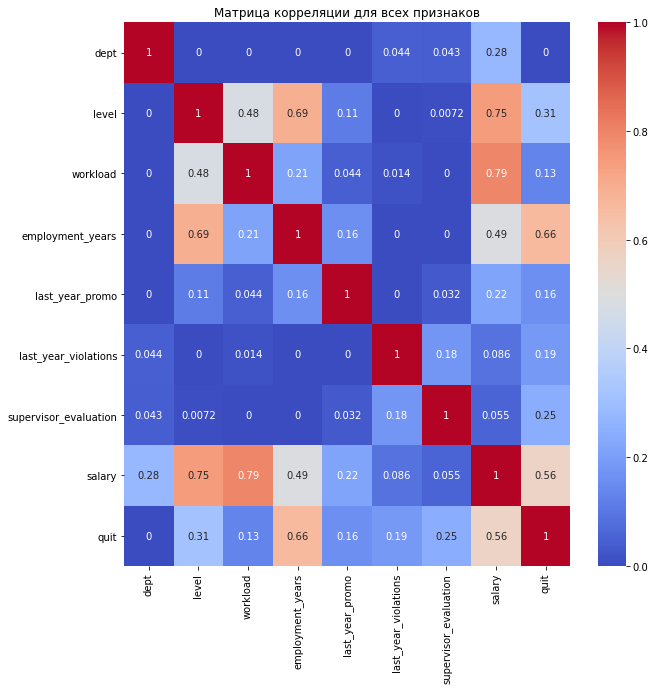

In [68]:
#Матрица корреляции со всеми признаками
plt.figure(figsize=(10, 10))
sns.heatmap(train_quit
    .drop('id', axis=1)
    .phik_matrix(interval_cols=[
        'salary']),
        annot=True, 
        cmap='coolwarm')
plt.title('Матрица корреляции для всех признаков')
plt.show();

### Тестовые данные

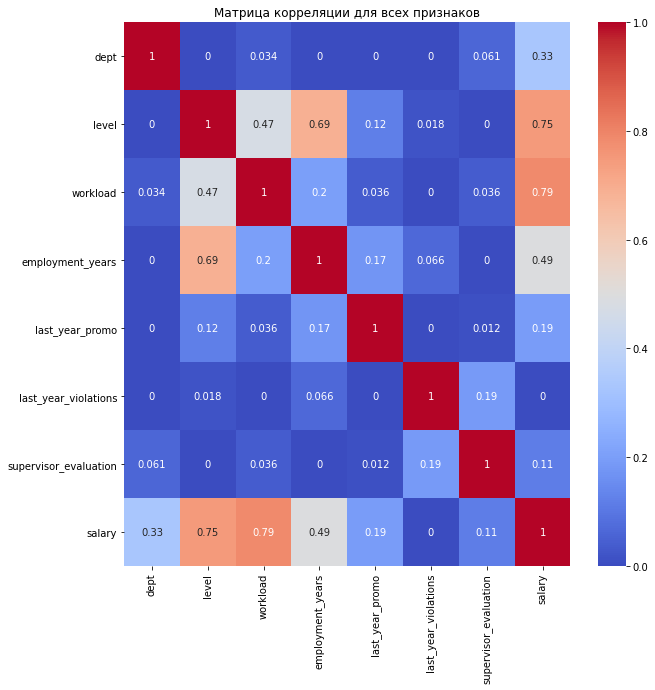

In [69]:
#Матрица корреляции со всеми признаками
plt.figure(figsize=(10, 10))
sns.heatmap(test_features
    .drop('id', axis=1)
    .phik_matrix(interval_cols=[
        'salary']),
        annot=True, 
        cmap='coolwarm')
plt.title('Матрица корреляции для всех признаков')
plt.show();

### Вывод

В ходе корреляционного анализа были сделаны следующие выводы:
- Зависимости тестовой и тренировочной выборок практически идентичны;
- Между признаками `workload` и `salary` в тестовой выборке наблюдается высокая корреляция (0.79), но поскольку она меньше 0.9, мы не можем говорить о мультиколлинеарности;
- Целевой признак `quit` имеет заметную корреляцию со следующими признаками:
    - `employment_years` (0.66);
    - `salary` (0.56).

## Построение моделей машинного обучения

### Подготовка данных

In [70]:
train_quit_encoded = best_model_preprocessor.transform(train_quit)

train_quit['job_satisfaction_rate_pred'] = best_model.predict(train_quit_encoded) 
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
0,723290,sales,middle,high,2,no,no,4,54000,no,0.647778
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.846364
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.340000
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


In [71]:
test_features_quit_encoded = best_model_preprocessor.transform(test_features_quit)

test_features_quit['job_satisfaction_rate_pred'] = best_model.predict(test_features_quit_encoded)
test_features_quit.drop('job_satisfaction_rate', axis=1, inplace=True)
test_features_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
0,485046,marketing,junior,medium,2,no,no,5,28800,no,0.885000
1,686555,hr,junior,medium,1,no,no,4,30000,no,0.678750
2,467458,sales,middle,low,5,no,no,4,19200,no,0.654000
3,418655,sales,middle,low,6,no,no,4,19200,no,0.655000
4,789145,hr,middle,medium,5,no,no,5,40800,no,0.825556


In [72]:
X_train_quit = train_quit.drop(['id', 'quit'], axis=1)
y_train_quit = train_quit['quit']
X_test_quit = test_features_quit.drop(['id', 'quit'], axis=1)
y_test_quit = test_features_quit['quit']

ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

print(X_train_quit.shape)
print(y_train_quit.shape)
print(X_test_quit.shape)
print(y_test_quit.shape)

(4000, 9)
(4000,)
(2000, 9)
(2000,)


In [73]:
label_encoder = LabelEncoder()

y_train_quit = label_encoder.fit_transform(y_train_quit)
y_test_quit = label_encoder.transform(y_test_quit)

print(label_encoder.classes_)

['no' 'yes']


### Разработка пайплайна

In [74]:
# Создаем итоговый пайплайн
pipe_final_quit = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [75]:
param_grid_quit = [
    # Словарь для модели DicisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__min_samples_split': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # Словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2 ,7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # Словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l2')],
        'models__C': [0.1, 1, 2, 3, 4, 5, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # Словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='linear', probability=True)],
        'models__C': [0.1,1,2,5,10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [76]:
randomized_search_quit = RandomizedSearchCV(
    pipe_final_quit, 
    param_grid_quit, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1,
    random_state=RANDOM_STATE
)

#обучение модели на тренировочной выборке
randomized_search_quit.fit(X_train_quit, y_train_quit);

In [77]:
print('Лучшая модель и её параметры:\n\n', randomized_search_quit.best_params_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search_quit.best_score_)

Лучшая модель и её параметры:

 {'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 9, 'models__max_features': 8, 'models__max_depth': 7, 'models': DecisionTreeClassifier(random_state=42)}
Метрика лучшей модели на кросс-валидации: 0.9256590441989287


In [78]:
best_model_quit = randomized_search_quit.best_estimator_['models']
best_model_preprocessor_quit = randomized_search_quit.best_estimator_['preprocessor']

X_test_encoded_quit = best_model_preprocessor_quit.transform(X_test_quit)
y_pred_quit = best_model_quit.predict(X_test_encoded_quit)

### Проверка на тестовых данных

In [79]:
y_test_proba_quit = randomized_search_quit.predict_proba(X_test_quit)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_quit, y_test_proba_quit)}')

Метрика ROC-AUC на тестовой выборке: 0.9174624399928879


### Анализ важности признаков

,Feature,Importance
11,remainder__job_satisfaction_rate_pred,0.357672
8,num__employment_years,0.338177
6,ord__level,0.139130
7,ord__workload,0.067294
10,num__salary,0.064356
9,num__supervisor_evaluation,0.022421
5,ohe__last_year_violations_yes,0.003826
4,ohe__last_year_promo_yes,0.002616
1,ohe__dept_purchasing,0.001975
2,ohe__dept_sales,0.001210


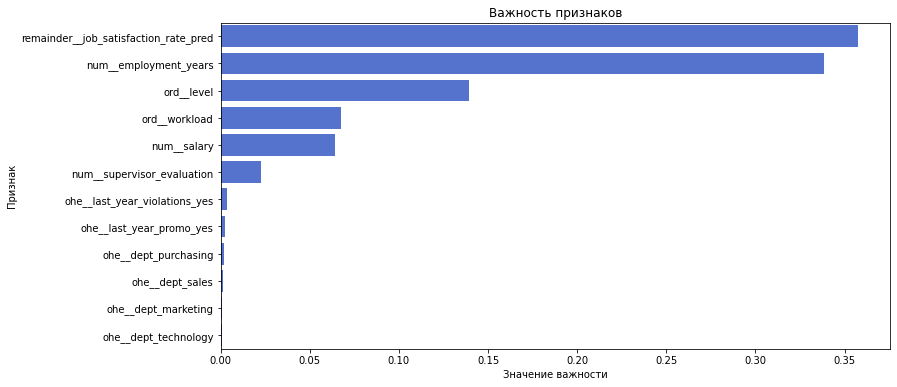

In [80]:
# Получение названий столбцов
feature_names = best_model_preprocessor_quit.get_feature_names_out()

feature_importances = pd.DataFrame(
    {
        'Feature': feature_names,
        'Importance': best_model_quit.feature_importances_
    }).sort_values('Importance', ascending=False)

display(feature_importances)

plt.figure(figsize=(12, 6))
plot = sns.barplot(data = feature_importances, x='Importance', y='Feature', color='#4169e1')
plot.set(
    title='Важность признаков',
    xlabel='Значение важности',
    ylabel='Признак')
plt.show()

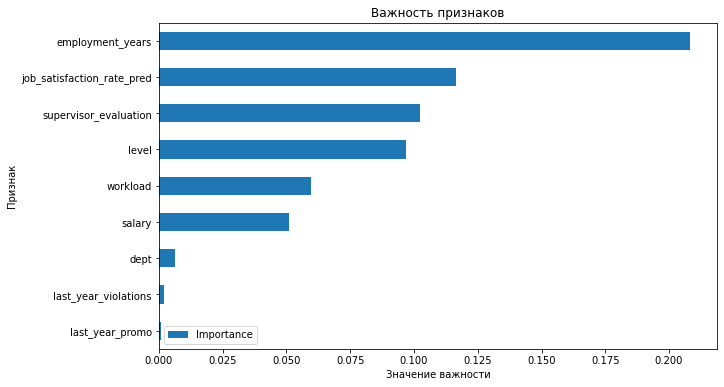

In [81]:
best_model_quit_an = randomized_search_quit.best_estimator_

# Оценим влияние признаков с помощью Permutation Importance
permutation = permutation_importance(best_model_quit_an, X_train_quit, y_train_quit, scoring = 'roc_auc')

feature_importance = pd.DataFrame({'Feature': X_train_quit.columns, 'Importance': permutation['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
plot = feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plot.set(
    title='Важность признаков',
    xlabel='Значение важности',
    ylabel='Признак')
plt.show()

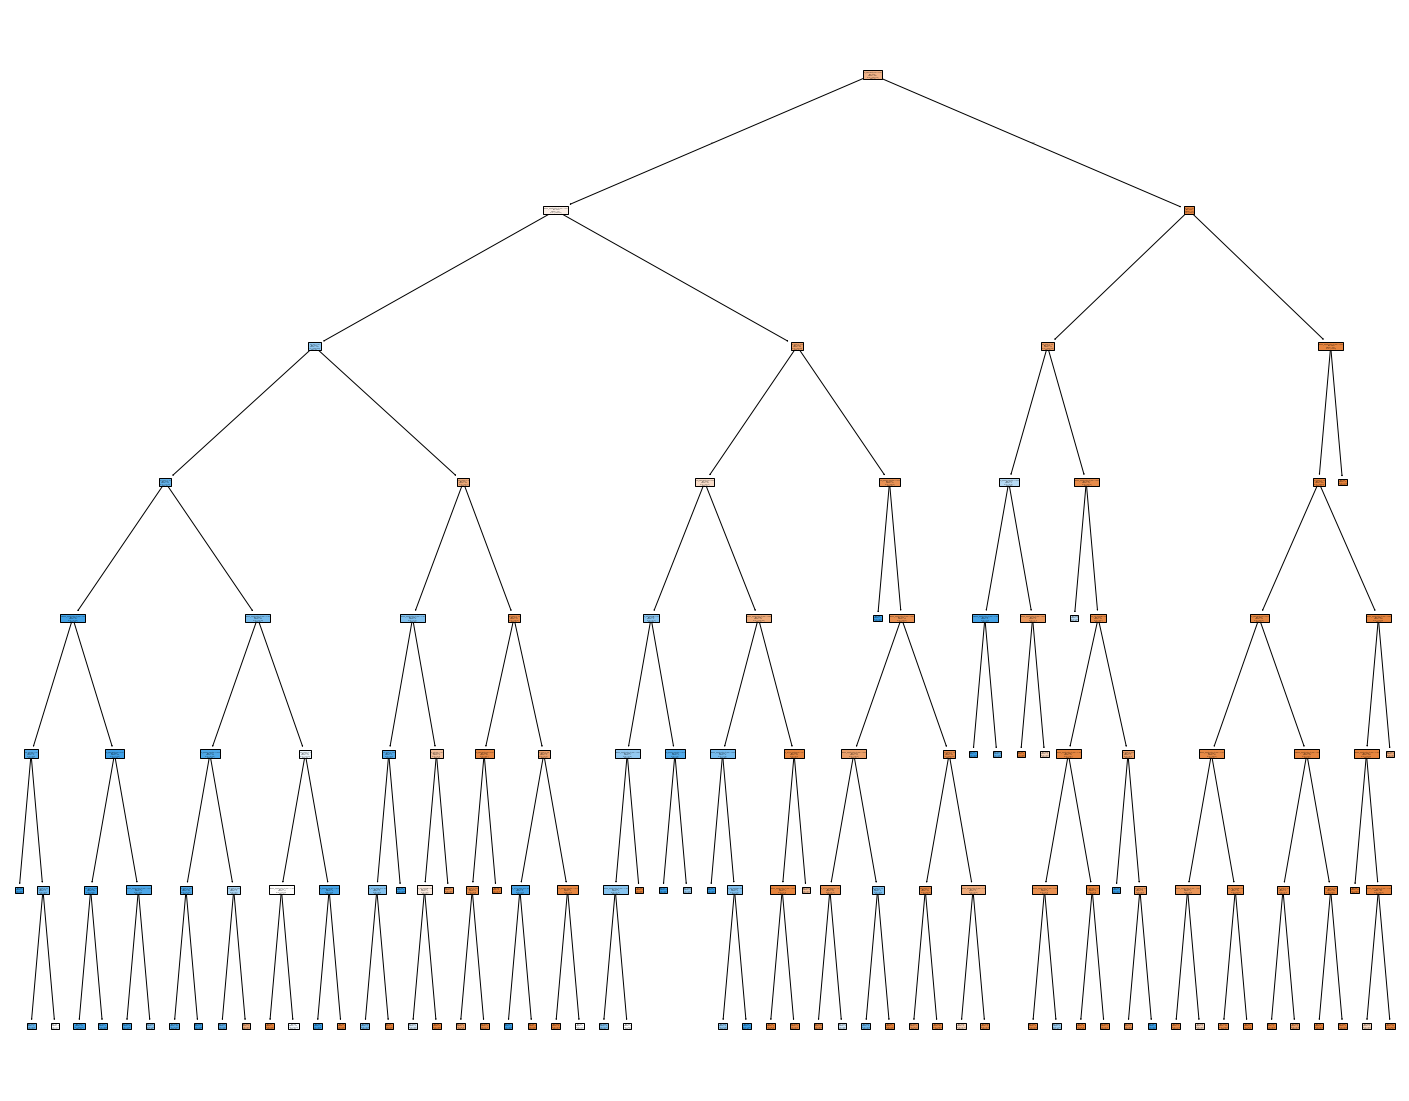

In [82]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_model_quit, 
                   feature_names=feature_names,  
                   class_names=label_encoder.classes_,
                   filled=True)

### Вывод

В ходе разработки моделей машинного обучения можно сделать следующие выводы:
- Моделью, показавшей наилучшие показатели, является модель DecisionTreeClassifier(max_depth=7, max_features=5, min_samples_split=6, random_state=42) со скелером StandardScaler();
- На тренировочных данных метрика ROC-AUC равна 0.924375;
- На тестовых данных метрика ROC-AUC равна 0.92373;
- Наиболее важными признаками модели являются:
    - employment_years (0.33)
    - supervisor_evaluation (0.25);
    - job_satisfaction_rate	(0.17);
    - level (0.11);
    - workload (0.10).

## Общий вывод

В ходе проведенного исследования был проделан следующий ряд работ и сделаны следующие выводы:


1. Открыт и изучен файл

    - Датасет `train_satisfaction`:
        - Всего в датасете 4000 строк и 10 столбцов;
        - Названия столбцов приведены к единому стилю;
        - Явные пропуски обнаружены в столбцах `dept` и `level` и будут заполнены в пайплайне часто встречающимся значением;
        - Данные имеют верный тип;
        - Необходимо проверить данные на дубликаты;
        - Явных выбросов не обнаружено.

    - Датасет `test_features`:
        - Всего в датасете 2000 строк и 9 столбцов;
        - Названия столбцов приведены к единому стилю;
        - Явные пропуски обнаружены в столбцах `dept` и `level` и будут заполнены в пайплайне часто встречающимся значением;
        - Данные имеют верный тип;
        - Необходимо проверить данные на дубликаты;
        - Явных выбросов не обнаружено.

    - Датасет `target_satisfaction`:
        - Всего в датасете 2000 строк и 2 столбца;
        - Названия столбцов приведены к единому стилю;
        - Явные пропуски не обнаружены;
        - Данные имеют верный тип;
        - Проверка на дубликаты не требуется;
        - Явных выбросов не обнаружено.
    - Датасет `train_quit`:
        - Всего в датасете 4000 строк и 10 столбцов;
        - Названия столбцов приведены к единому стилю;
        - Явных пропускиов не обнаружено;
        - Данные имеют верный тип;
        - Необходимо проверить данные на дубликаты;
        - Явных выбросов не обнаружено.

    - Датасет `target_quit`:
        - Всего в датасете 2000 строк и 2 столбца;
        - Названия столбцов приведены к единому стилю;
        - Явных пропусков не обнаружено;
        - Данные имеют верный тип;
        - Необходимо проверить данные на дубликаты;
        - Явных выбросов не обнаружено.
        
    - Данные были признаны пригодными для исследования.
    
    
2. Проведена предобработка данных:
    - Датасет `train_satisfaction`:
        - Дубликатов не обнаружено;
        - Обработаны опечатки (вероятно, человеческий фактор).
    - Датасет `test_features`:
        - Дубликатов не обнаружено;
        - Обработаны опечатки (вероятно, человеческий фактор).
    - Датасет `target_satisfaction`:
        - Предобработка не требуется.
    - Датасет `train_quit`:
        - Дубликатов не обнаружено;
        - Обработаны опечатки (вероятно, человеческий фактор).
    - Датасет `target_quit`:
        - Предобработка не треубется.
        
        
3. Проведен исследовательский анализ данных №1:
    - Признак `dept`. 
        - Распределение работников в различных отделах имеет несбалансированный вид, наибольшее количество сотрудников находится в отделах: sales (38%) и technology (22%).
    - Признак `level`. 
        - Распределение работников с разным уровнем квалификации имеет следующий вид:
            - junior (47%);
            - middle (44%);
            - senior (9%).
    - Признак `workload`. 
        - Распределение работников с разным уровнем нагрузки имеет следующий вид:
            - medium (52%);
            - low (30%);
            - high (18%).
    - Признак `employment_years`. 
        - Распределение длительности работы в компании имеет убывающий тренд с максимумом в 1, то есть чем дольше человек работает в компании, тем меньше вероятность, что он останется.
    - Признак `last_year_promo`. 
        - Распределение повышения за последний год показывает, что большинство сотрудников (97%) не получало повышения.
    - Признак `last_year_violations`. 
        - Распределение нарушений трудового договора имеет несбалансированный вид. Это является нормальной ситуацией, что большая часть работников (87%) не нарушало трудовой договор. Для более детального исследования можно добавить информацию, по каким пунктам нарушили его остальные 13%.
    - Признак `supervisor_evaluation`. 
        - Оценки начальников имеют вид номрального с модой в 4. Можно заметить, что начальники в основном оценивают сотрудников, как средних(3-4), в то время, как отличных и совсем плохих гораздо меньше.
    - Признак `salary`. 
        - Распределение размера зарплаты имеет вид нормального с медианой в 30000, от выбросов нет необходимости избавляться, потому что данные вполне реалистичные.
    - Признак `job_satisfaction_rate`. 
        - Распределение уровня удовлетворенности работой имеет среднее значение 0.53, выбросов не обнаружено.
    
    
4. Проведен корреляционный анализ №1:
    - Зависимости тестовой и тренировочной выборок практически идентичны;
    - Между признаками `workload` и `salary` наблюдается высокая корреляция (0.79), но поскольку она меньше 0.9, мы не можем говорить о мультиколлинеарности;
    - Целевой признак `job_satisfaction_rate` имеет заметную и высокую корреляцию со следующими признаками:
        - `last_year_violations` (0.56);
        - `supervisor_evaluation` (0.76).

    
5. Построены модели машинного обучения при помощи пайплайнов №1:
    - Моделью, показавшей наилучшие показатели SMAP, является модель DecisionTreeRegressor(max_depth=16, min_samples_split=7, max_features=13, random_state=42) со скелером StandardScaler();
    - На тестовых данных лучшая модель показала 13.8 баллов;
    - Наиболее важными признаками модели являются:
        - supervisor_evaluation (0.67);
        - salary (0.09);
        - employment_years (0.08).
    
    
6. Проведен исследовательский анализ данных №2:
    - Признак `dept`. 
        - Распределение работников в различных отделах имеет несбалансированный вид, наибольшее количество сотрудников находится в отделах: sales (36%) и technology (23%). 
        - Распределение признака в выборке уволившихся и неуволившихся практически идентичное.
    - Признак `level`. 
        - Распределение работников с разным уровнем квалификации имеет следующий вид:
            - junior (49%);
            - middle (42%);
            - senior (9%).
        - Среди уволившихся большинство (89%) являются сотрудниками уровня Junior, в то время как у неуволившихся большинство (55%) сотрудников уровня Middle.
    - Признак `workload`. 
        - Распределение работников с разным уровнем нагрузки имеет следующий вид:
            - medium (53%);
            - low (30%);
            - high (17%).
        - Соотношение уровней у неуволившихся сотрудников схоже с основной выборкой. Уволившиеся сотрудники в основном имеют следующие уровни загруженности:
            - low (46%);
            - medium (43%);
            - high (11%).
    - Признак `employment_years`. 
        - Распределение длительности работы в компании имеет убывающий тренд с максимумом в 1, то есть чем дольше человек работает в компании, тем меньше вероятность, что он останется.
        - Уволившиеся сотрудники увольняются в основном в первые 3 года работы, в основном в первый год, в то время, как неуволившиеся работают равномерно несколько лет.
    - Признак `last_year_promo`. 
        - Распределение повышения за последний год показывает, что большинство сотрудников (97%) не получало повышения.
        - Среди уволившихся сотрудников лишь 1 человек из 1127 получил повышение, в то время как у неуволившихся 4 процента получили повышение.
    - Признак `last_year_violations`. 
        - Распределение нарушений трудового договора имеет несбалансированный вид. Это является нормальной ситуацией, что большая часть работников (87%) не нарушало трудовой договор. Для более детального исследования можно добавить информацию, по каким пунктам нарушили его остальные 13%.
        - Среди уволившихся нарушений трудового договора выше, чем в основной выборке, вероятно, это связано с тем, что после нарушения трудового договора человек не хочет оставаться или вынужден уйти с работы. У неуволившихся значение нарушений наоборот становится меньше.
    - Признак `supervisor_evaluation`. 
        - Оценки начальников имеют вид номрального с модой в 4. Можно заметить, что начальники в основном оценивают сотрудников, как средних(3-4), в то время, как отличных и совсем плохих гораздо меньше.
        - Распределение уволившихся свдигается в сторону меньших баллов, так например, мода для уволившихся сотрудников равна 3. Статистически есть основания полагать, что действительно оценки руководителей ниже у уволившихся сотрудников.
    - Признак `salary`. 
        - Распределение размера зарплаты имеет вид нормального с медианой в 30000, от выбросов нет необходимости избавляться, потому что данные вполне реалистичные.
        - По распределению уволившихся можно заметить, что их зарплата ниже, чем у неуволившихся. Статистически доказано, что с большей долей вероятности зарплата уволившихся сотрудников ниже. Это подтверждено также таблицей с основными статистическими характеристиками, средняя зарплата уволившихся равна 23885, в то время как у неуволившихся 37702.
    - Признак `quit`. 
        - Распределение признака имеет несбалансированный вид:
            - Неуволившиеся (72%);
            - Уволившиеся (28%).
    - Портрет уволившегося сотрудника.
        - Наиболее распространненый уволившийся сотрудник - это сотрудник уровня Junior, проработавший в компании один год со средней или низкой нагрузкой. Есть основания утверждать следующее:
            - Уволившиеся сотрудники имеют меньшую зарплату;
            - Уволившиеся сотрудники не получали повышения в прошедшем году;
            - Уволившиеся сотрудники имеют более низкую оценку руководителя;
            - Уволившиеся сотрудники менее удовлетворены работой.


7. Проведен корреляционный анализ №2:
    - Зависимости тестовой и тренировочной выборок практически идентичны;
    - Между признаками `workload` и `salary` в тестовой выборке наблюдается высокая корреляция (0.79), но поскольку она меньше 0.9, мы не можем говорить о мультиколлинеарности;
    - Целевой признак `quit` имеет заметную корреляцию со следующими признаками:
        - `employment_years` (0.66);
        - `salary` (0.56).


8. Построены модели машинного обучения при помощи пайплайнов №2:
    - Моделью, показавшей наилучшие показатели, является модель DecisionTreeClassifier(max_depth=7, max_features=5, min_samples_split=6, random_state=42) со скелером StandardScaler();
    - На тренировочных данных метрика ROC-AUC равна 0.924375;
    - На тестовых данных метрика ROC-AUC равна 0.92373;
    - Смещение и разброс модели малы, что говорит о том, что модель хорошо обучилась;
    - Наиболее важными признаками модели являются:
        - employment_years (0.33)
        - supervisor_evaluation (0.25);
        - job_satisfaction_rate	(0.17);
        - level (0.11);
        - workload (0.10).
    

9. Итоговый вывод:
    - Разработанные модели машинного обучения показали хорошие результаты на контрольной выборке, с их помощью можно прогнозировать удовлетворенность сотрудников работой и их отток. На основании этого на уровень удовлетворенности наибольшее влияние оказывают оценка руководителя и зарплата, вероятно, попадая в коллектив новый сотрудник еще не может до конца осовиться, у него хуже получается работа и соответственно руководитель оценивает его работу ниже. Думаю стоит рассмотреть введение "санитарного" этапа или более подробно рассказывать сотруднику на этапе собеседдований, чтобы он быстрее вливался в новую работу. Опираясь на портрет уволившегося сотрудника можно порекоммендовать следующие шаги:
        - Сформировать понятную систему индексации зарплаты;
        - Создать этап обучения и адаптации для новых сотрудников уровня Junior;
        - Добавить компенсации некоторых дополнительных программ (дополнительное образование, фитнес и пр.);
        - Сделать прозрачную систему повышений, чтобы это мотивировало новых сотруников понимать в какую сторону они могут двигаться и развиваться.
    - Поскольку предложенные шаги влекут за собой финансовые траты, необходимо рассмотреть их финансовую целесообразность и провести анализ.